#Predicting Crypto Market Movements and Optimizing Portfolios with Machine Learning



## Research Question and Project Overview



---


***How effective are machine learning models in predicting cryptos prices and movements, and how can these predictions be leveraged for portfolio management strategies?***


---


This project explores the application of machine learning models in cryptocurrency market prediction, focusing on both price movement classification (up, down, neutral) and direct price forecasting. Using historical financial data—comprising open, high, low, close (OHLC) prices, volume and other technical indicators — three machine learning approaches were developed and compared:

1.   **Regression Models (Linear & Polynomial)**: Used as a baseline to highlight their limitations in price prediction.
2.   **Long Short-Term Memory (LSTM)**: A recurrent neural network (RNN) capable of capturing temporal dependencies in financial time series.
3. **Random Forest**: An ensemble learning method to assess the importance of different features in price movement prediction.

The second part of the project applies the best-performing model to a **rule-based portfolio management strategy**. The model’s predictions are actively used to adjust portfolio allocation:

1. If the model predicts an upward movement, the portfolio increases exposure to the asset (increased weight).
2. If the model predicts a downward movement, the portfolio reduces exposure or shorts the asset.
3. If the model predicts a neutral movement, a balanced allocation is maintained.

The project then evaluates the strategy’s effectiveness by comparing its returns and risk-adjusted performance to benchmark approaches (e.g., holding a static crypto portfolio equally weighted).

This evaluation will determine the practical viability of machine learning-based price forecasts in real-world investment decision-making.

## Dataset Description


#### Source
Data was sourced from Yahoo Finance through Python’s *yfinance* library and subsequently stored into CSV files to overcome API limits.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd

# Define tickers and date range
cryptos = ['ETH-USD', 'BTC-USD', 'USDT-USD', 'DOGE-USD']
start_date = '2018-01-01'
end_date = '2025-01-01'

# Create an empty dictionary
crypto_data = {}

# Try downloading data: if API fails, load precedently saved CSV files
for ticker in cryptos:
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        if not df.empty:
            df.to_csv(f"{ticker}.csv")
            df=df.iloc[2:,:]
            df.columns = ['Date','Open','High','Low','Adj. Close','Volume']
            df['Date'] = pd.to_datetime(df['Date'])  # Convert date
            df.set_index('Date', inplace=True)
            crypto_data[ticker] = df
    except:
        pass


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
if not crypto_data:
    for ticker in cryptos:
        crypto_data[ticker] = pd.read_csv(f"{ticker}.csv", skiprows=2) # Skip first 2 rows
        crypto_data[ticker].columns = ['Date','Open','High','Low','Adj. Close','Volume']
        crypto_data[ticker]['Date'] = pd.to_datetime(crypto_data[ticker]['Date'])  # Convert date
        crypto_data[ticker].set_index('Date', inplace=True)


#### Timeframe
Daily cryptocurrency price data are used, spanning from January 1, 2018, to January 1, 2025.

#### Cryptocurrency Selection

The dataset consists of data for four major cryptocurrencies: Ethereum (ETH), Bitcoin (BTC), Dogecoin (DOGE), and Tether (USDT).

The choice was determined by the need of providing a diversified and representative sample of the market for cryptocurrencies, ranging from highly volatile (DOGE) to relatively stable (USDT), and the most commonly used assets in the crypto market (BTC and ETH).

- Market Leaders: Bitcoin (BTC) and Ethereum (ETH) are the two largest and most widely recognized cryptocurrencies in terms of market capitalization, liquidity, and adoption. These two assets are often used as benchmarks for measuring the overall market sentiment and trends in the cryptocurrency space.

- Emerging Assets: Dogecoin (DOGE), initially created as a meme coin, has gained significant attention due to its adoption in various high-profile projects and its use in community-driven initiatives. Its volatile price action and growing market presence make it an interesting subject for predictive modeling.

- Stablecoin Representation: Tether (USDT) was selected as a representative of stablecoins, which are pegged to a stable asset (like the US dollar). Including a stablecoin helps to understand the behavior of less volatile assets in a portfolio that includes more speculative cryptocurrencies.


#### Features Description

| **Feature**    | **Description**                                                                                                                                       |
|----------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Date**       | Represents the date for which the data point is recorded. It helps in analyzing the temporal progression of cryptocurrency prices.                    |
| **Open**       | The price of the cryptocurrency at the beginning of the trading day. Provides insight into market sentiment at the start of each day’s trading session.  |
| **High**       | The highest price reached during the trading day. A key indicator of bullish behavior and shows the peak price achieved during the daily trading session.|
| **Low**        | The lowest price reached during the trading day. Helps assess market corrections or dips and evaluates risk levels within a given time frame.           |
| **Adj. Close** | The adjusted closing price, accounting for stock splits or dividends. Although less relevant for cryptocurrencies, it ensures accurate analysis by adjusting for unusual market events.|
| **Volume**     | The total number of cryptocurrency units traded during the day. Reflects liquidity and market interest, with higher volume typically indicating stronger market participation. |


#### Additional Features
Some additional features were added to the original dataset: technical indicators and target variables (needed for analysis).

| **Feature**       | **Description**                                                                                                                                                               |
|-------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **RSI (Relative Strength Index)** | A momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and helps identify overbought (>70) or oversold (<30) conditions. |
| **EMAM (Medium-Term Exponential Moving Average)** | An exponential moving average (EMA) with a medium-length period. It smooths price fluctuations to highlight trends. |
| **EMAS (Short-Term Exponential Moving Average)** | A short-period EMA that reacts more quickly to price changes, useful for identifying short-term momentum shifts. |
| **EMAF (Fast Exponential Moving Average)** | A very short-period EMA, even more sensitive to recent price movements, often used for detecting immediate trend changes. |
| **Target** | The difference between the **Adjusted Close** and the next's window-size **Adjusted Close** price.  |
| **Pct Return (Percentage Return)** | Total percentage return over the window time. Calculated on the **Adjusted Close** price.  |
| **Target Class** | A classification label based on the **distribution of percentage returns for each crypto**: <br> **1 (Up)** if `pct return` > 66th percentile <br> **0 (Down)** if `pct return` < 33rd percentile <br> **2 (Neutral)** if `pct return` is in between. |


#### Target Variable: In depth
Using simply the next day's price as the target (*y*), might imply getting misleadingly good-looking results.

- Crypto **prices move slowly** (most of the time), so the best guess is often just ** yesterday’s price**.
- The model might learn to just predict values close to yesterday’s price instead of learning real patterns.
- The small errors make the model look “accurate,” but it's not actually useful for making trading decisions.

This is the so called **naive persistence problem**.


Possible Solution:
- **Classification** **(1 = Up, 0 = Down, 2 = Neutral)**
- Classify whether the price will go Up, Down or will stay Neutral
- Labeling is based on Percentage Return's distribution

## Data Preprocessing

#### Data Cleaning

In [5]:
# Formatting original data
cryptos = ['ETH-USD', 'BTC-USD', 'USDT-USD', 'DOGE-USD']
for ticker in crypto_data:
    crypto_data[ticker] = pd.read_csv(f"{ticker}.csv", skiprows=2)
    crypto_data[ticker].columns = ['Date','Open','High','Low','Adj. Close','Volume']  # Rename columns
    crypto_data[ticker]['Date'] = pd.to_datetime(crypto_data[ticker]['Date'])  # Convert date
    crypto_data[ticker].set_index('Date', inplace=True)  # Set Date as index

In [6]:
# Display the first few rows of each dataframe
for ticker in crypto_data:
  print(f"Showing data for {ticker}:")
  display(crypto_data[ticker].head())

Showing data for ETH-USD:


,Open,High,Low,Adj. Close,Volume
Date,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824


Showing data for BTC-USD:


,Open,High,Low,Adj. Close,Volume
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


Showing data for USDT-USD:


,Open,High,Low,Adj. Close,Volume
Date,,,,,
2018-01-01,1.007280,1.01536,1.001530,1.01255,1685299968
2018-01-02,1.004900,1.00988,0.993250,1.00574,2635859968
2018-01-03,1.013440,1.02328,1.002640,1.00660,2471689984
2018-01-04,1.002530,1.01618,0.993822,1.01320,3200130048
2018-01-05,0.998634,1.00501,0.985915,1.00175,3096620032


Showing data for DOGE-USD:


,Open,High,Low,Adj. Close,Volume
Date,,,,,
2018-01-01,0.008909,0.009063,0.008101,0.009031,50616900
2018-01-02,0.009145,0.009598,0.008551,0.008873,89424096
2018-01-03,0.009320,0.009584,0.008882,0.009088,66349900
2018-01-04,0.009644,0.010036,0.008768,0.009346,108986000
2018-01-05,0.012167,0.012283,0.009589,0.009660,212383008


In [7]:
# Check consistent dimensions
for ticker in crypto_data:
  print(crypto_data[ticker].shape)

(2557, 5)
(2557, 5)
(2557, 5)
(2557, 5)


In [8]:
# Check the number of NaNs for each column in each ticker
for ticker in cryptos:
    print(f"Missing values for {ticker}:")
    print(crypto_data[ticker].isna().sum())
    print("\n")


Missing values for ETH-USD:
Open          0
High          0
Low           0
Adj. Close    0
Volume        0
dtype: int64


Missing values for BTC-USD:
Open          0
High          0
Low           0
Adj. Close    0
Volume        0
dtype: int64


Missing values for USDT-USD:
Open          0
High          0
Low           0
Adj. Close    0
Volume        0
dtype: int64


Missing values for DOGE-USD:
Open          0
High          0
Low           0
Adj. Close    0
Volume        0
dtype: int64




#### Data Transformation
- Encoding Categorical Data: Labeling;
- Feature Engineering: Creating new features from existing ones; Adding useful technical indicators and Target Variables;


In [9]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=e4b176290db13c41bf8f4ea367f0135123691f537358c1fa907e8dbe44130706
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [10]:
import pandas_ta as ta
import numpy as np

# Forecasting Window
window = 1

# Fibonacci Levels
fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786]

for ticker in cryptos:
    df = crypto_data[ticker]

    # Add technical indicators
    df['RSI'] = ta.rsi(df['Adj. Close'], length=15)
    df['EMAF'] = ta.ema(df['Adj. Close'], length=20)
    df['EMAM'] = ta.ema(df['Adj. Close'], length=100)
    df['EMAS'] = ta.ema(df['Adj. Close'], length=150)

    # Bollinger bands
    bbands_df = ta.bbands(df['Adj. Close'], length=20, std=2)
    df['Bollinger_Lower'] = bbands_df['BBL_20_2.0']
    df['Bollinger_Middle'] = bbands_df['BBM_20_2.0']
    df['Bollinger_Upper'] = bbands_df['BBU_20_2.0']

    # Fibonacci Levels
    recent_high = df['High'].rolling(window=20).max()
    recent_low = df['Low'].rolling(window=20).min()
    for level in fib_levels:
       df[f'Fib_{level}'] = recent_high - (recent_high - recent_low) * level

    # Awesome Oscillator
    df['AO'] = ta.ao(df['High'], df['Low'])

    # Ichimoku Cloud
    ichimoku_df = ta.ichimoku(df['High'], df['Low'], df['Adj. Close'])

    df['Tenkan_Sen'] = ichimoku_df[0]['ITS_9']
    df['Kijun_Sen'] = ichimoku_df[0]['IKS_26']
    df['Senkou_Span_A'] = ichimoku_df[0]['ISA_9']
    df['Senkou_Span_B'] = ichimoku_df[0]['ISB_26']
    df['Chikou_Span'] = ichimoku_df[0]['ICS_26']

    # Commodity Channel Index
    df['CCI'] = ta.cci(df['High'],
                       df['Low'],
                       df['Adj. Close'], length=20)

    # Calculate Target: Price Difference (current day Closing to Window day's Close)
    df['Target'] = df['Adj. Close'].shift(-window) - df['Adj. Close']

    # Calculate Pct Return: total percentage return over the window time
    df['Pct Return'] = (df['Adj. Close'].shift(-window) - df['Adj. Close']) / df['Adj. Close']

    # Calculate quantile thresholds for classification (down, neutral, up)
    down_threshold = df['Pct Return'].quantile(0.33)
    up_threshold = df['Pct Return'].quantile(0.66)

    # Classify based on percentage return
    df['TargetClass'] = np.where(df['Pct Return'] > up_threshold, 1,
                                 np.where(df['Pct Return'] < down_threshold, 0, 2))

    # Save the updated DataFrame back to the dictionary
    crypto_data[ticker] = df


In [11]:
# Display the first few rows of each dataframe
for ticker in crypto_data:
  print(f"Showing data for {ticker}:")
  display(crypto_data[ticker].head())
  print(crypto_data[ticker].shape)

Showing data for ETH-USD:


,Open,High,Low,Adj. Close,Volume,RSI,EMAF,EMAM,EMAS,Bollinger_Lower,...,AO,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI,Target,Pct Return,TargetClass
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1055.750000,NaN,16.588989,0.021950,1
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1111.780029,NaN,113.653992,0.147154,1
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1246.699951,NaN,75.713013,0.085455,1
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1184.130005,NaN,14.036987,0.014596,1
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1071.089966,NaN,19.403992,0.019886,1


(2557, 27)
Showing data for BTC-USD:


,Open,High,Low,Adj. Close,Volume,RSI,EMAF,EMAM,EMAS,Bollinger_Lower,...,AO,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI,Target,Pct Return,TargetClass
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11174.900391,NaN,-487.200195,-0.034523,0
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11475.299805,NaN,1353.200195,0.099317,1
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11755.500000,NaN,292.500000,0.019528,1
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11306.799805,NaN,206.500000,0.013523,1
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10108.200195,NaN,1984.899414,0.128247,1


(2557, 27)
Showing data for USDT-USD:


,Open,High,Low,Adj. Close,Volume,RSI,EMAF,EMAM,EMAS,Bollinger_Lower,...,AO,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI,Target,Pct Return,TargetClass
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.007280,1.01536,1.001530,1.01255,1685299968,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.002810,NaN,-0.00681,-0.006726,0
2018-01-02,1.004900,1.00988,0.993250,1.00574,2635859968,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.996548,NaN,0.00086,0.000855,1
2018-01-03,1.013440,1.02328,1.002640,1.00660,2471689984,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.988440,NaN,0.00660,0.006557,1
2018-01-04,1.002530,1.01618,0.993822,1.01320,3200130048,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.998672,NaN,-0.01145,-0.011301,0
2018-01-05,0.998634,1.00501,0.985915,1.00175,3096620032,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.992538,NaN,-0.00147,-0.001467,0


(2557, 27)
Showing data for DOGE-USD:


,Open,High,Low,Adj. Close,Volume,RSI,EMAF,EMAM,EMAS,Bollinger_Lower,...,AO,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI,Target,Pct Return,TargetClass
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.008909,0.009063,0.008101,0.009031,50616900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.007240,NaN,-0.000158,-0.017495,0
2018-01-02,0.009145,0.009598,0.008551,0.008873,89424096,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.007409,NaN,0.000215,0.024231,1
2018-01-03,0.009320,0.009584,0.008882,0.009088,66349900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.007401,NaN,0.000258,0.028389,1
2018-01-04,0.009644,0.010036,0.008768,0.009346,108986000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.006969,NaN,0.000314,0.033597,1
2018-01-05,0.012167,0.012283,0.009589,0.009660,212383008,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.006001,NaN,0.002566,0.265632,1


(2557, 27)


#### Technical Indicators: In Depth

##### Bolllinger Bands

In [ ]:
start_date = "2024-01-01"
end_date = "2024-06-30"
df = crypto_data['BTC-USD'].loc[start_date:end_date]

***What:***
- They are used to measure market volatility and identify potential trend reversals or breakouts.

***Why:***
- Cryptocurrencies are higly volatile,this indicator can be particularly useful for detecting possible buying and selling opportunities.

***Components :***

1. **Middle Band (SMA)**

This is a Simple Moving Average (SMA) of the Adjusted Close price over a chosen period (n).
It represents the average price and serves as the baseline for the upper and lower bands.

$Middle Band=SMA
n
​
 (P)$

 2. **Upper Band**

The upper band is calculated by adding a multiple (k) of the standard deviation (σ) to the middle band.
It helps identify overbought conditions in the market.

$Upper Band=SMA
n
​
 (P)+k⋅σ
n
​
$

3. **Lower Band**

The lower band is obtained by subtracting a multiple (k) of the standard deviation (σ) from the middle band.
It helps identify oversold conditions in the market.

$Lower Band=SMA
n
​
 (P)−k⋅σ
n
​
$

*INTERPRETATION :*

*  **Volatility Analysis**:
  - When the band expands the volatility of the market increase, indicating a strong price movement
  - When there is a band contraction market volatility decrease, indicating a consolidation phase

* **Mean Reversion**
  - If the price reach or exceed the upper band, it indicate that the assets is overbought, suggesting a possible price decline
  - if the price reach or fall under the lower band, it indicate that the asset is oversold, suggesting a possible upward reversal

* **Trend Continuation signal**
- Breakout on the upper or lower band can indicatea strong bullish/bearish momentum.









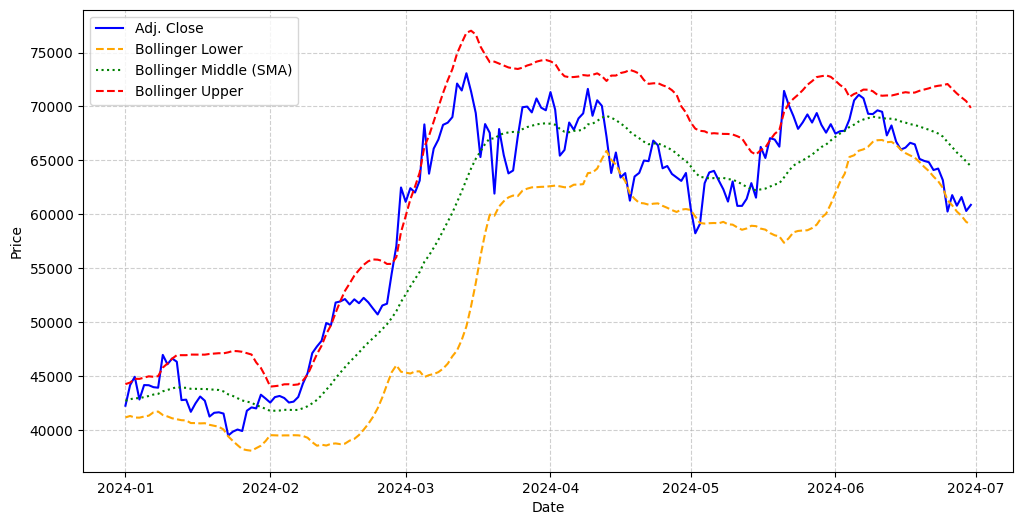

In [ ]:
import matplotlib.pyplot as plt

df = crypto_data['BTC-USD'].loc[start_date:end_date]
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Adj. Close'], label='Adj. Close', color='blue')
plt.plot(df.index, df['Bollinger_Lower'], label='Bollinger Lower', color='orange', linestyle='dashed')
plt.plot(df.index, df['Bollinger_Middle'], label='Bollinger Middle (SMA)', color='green', linestyle='dotted')
plt.plot(df.index, df['Bollinger_Upper'], label='Bollinger Upper', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


##### Fibonacci Retracement


***What:***
- It helps identifying potential support and resistance zones based on historical price movements.
- These levels are derived from the Fibonacci sequence and are commonly applied in financial markets to anticipate price corrections, trend reversals, and continuation patterns.

***Components:***

* Fibonacci levels are computed using "High" and "Low" to identify potential retracement levels.
* The usual ratios applied to define the fibonacci level are 23.6%, 38.2%, 50%, 61.8% and 78.6%.

Each level represent a possible percentage retracement of the price movement from the highest to the lowest point given a defined period (We use the default period of 20).

$Fibonacci Level = RecentHigh - (Retracement Percentage
 ⋅ (RecentHigh - RecentLow))$

 RecentHigh = Highest price in the defined period

 RecentLow = Lowest price in the defined period


 *Interpretation :*
* **Support and Resistance**
 - When the price approach a Fibonacci level from above, it may work as a support for preventing further decline
 - When the price approach from below Fibonacci Levels works as a resistance point to stop potential upwarding trend

* **Breakouts and Reversal**
  - If the price breaks above a Fibonacci Levels, it may shown a continuos upward trend
  -  If the price don't break a levels it shown a possible reversal process (changing in trend direction)


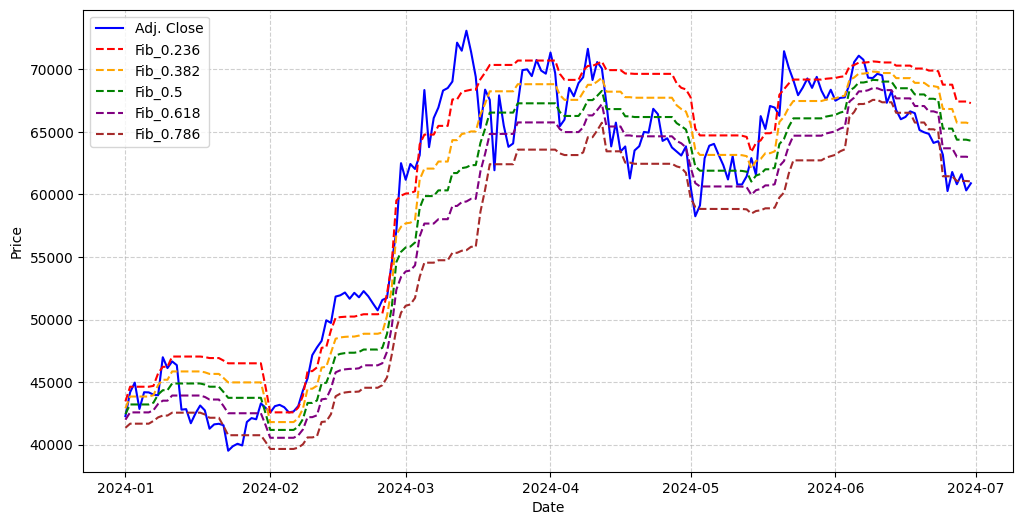

In [ ]:
#Visualization
plt.figure(figsize=(12,6))
df = crypto_data['BTC-USD'].loc[start_date:end_date]
plt.plot(df.index, df['Adj. Close'], label = 'Adj. Close', color = 'blue')
fib =  [col for col in df.columns if 'Fib' in col]
colors = ['red', 'orange', 'green', 'purple', 'brown']

for i, level in enumerate(fib):
  plt.plot(df.index, df[level], label = level, color = colors[i], linestyle = '--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, linestyle = '--', alpha = 0.6)

##### Awesome Oscillator

***What:***
- Is a momentum-based indicator used to evaluate trend-direction and strength, by comparing short and long term momentum to identify potential change inside the trend.

***Components :***

$AO=SMA
5
​
 (MP)−SMA
34
​
 (MP)$

Is based on the difference between two SMA, evaluated on a short-term momentum and a long-term momentum.

***Interpretation :***

It fluctuates above and below the zero line, providing signals for trend strength and potential reversals.

* **Zero Line Crossovers**

  - AO crosses above zero → Bullish signal (momentum increasing, potential uptrend).
  - AO crosses below zero → Bearish signal (momentum weakening, potential downtrend).
* **Twin Peaks**

  - Bullish Twin Peaks: Two lows below zero, where the second is higher → potential uptrend.
  - Bearish Twin Peaks: Two highs above zero, where the second is lower → potential downtrend.

* **Momentum Shift**

  - Bullish Saucer: AO is above zero, turns red briefly, then green → uptrend continuation.
  - Bearish Saucer: AO is below zero, turns green briefly, then red → downtrend continuation.

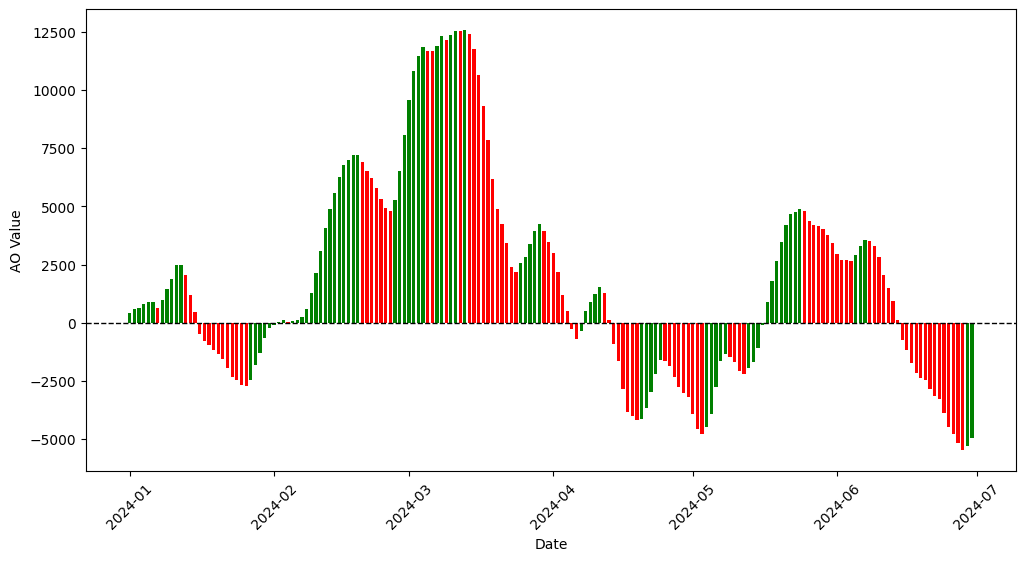

In [ ]:
df = crypto_data['BTC-USD'].loc[start_date:end_date]
ao_values = df['AO']
colors = ['green' if ao_values.iloc[i] > ao_values.iloc[i-1] else 'red' for i in range(1, len(ao_values))]
colors.insert(0, colors[0])

plt.figure(figsize=(12,6))
plt.bar(df.index, ao_values, color=colors, width=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('AO Value')

plt.xticks(rotation=45)
plt.show()

##### Ichimoku Cloud

***What:***
- Is a tool used in order to have insight about trend direction, support/resistance levels and momentum.

***Components :***

1. **TenkanSen**(Conversion Line) Short-term trend indicator. (Usually evaluated over the 9 last periods)

- $TenkanSen = (HighestHigh + LowestLow)/2$

2. **KijunSen** (Base Line) Medium-term trend indicator (Usually evaluated over the 26 last periods)

- $KijunSen = (HighestHigh + LowestLow)/2$

3. **SenkouSpanA** lower boundary of the cloud, evaluated from the average of the short and medium trend

- $Senkou Span A = (TenkanSen - KijunSen)/2$

4. **SenkouSpanB** upper boundary of the cloud, representing the long term trend. (Usually evaluatte don the last 52 periods)

- $SenkouSpanB = (HighestHigh + LowestLow)/2$

5. Chikou Span (Lagging Line) is the closing price shifted backward on a 26 period

***Interpretation :***

* **Trend**
 - If the price is above the cloud we have a momentum increasing and a possible uptrend
 - If the price is under the cloud we have a momentum decreasing and a possible downtrend
* **Cloud**
 - When the cloud is green there is a Bullish signal (increasing momentum and uptrend)
 - When the cloud is red there is a Bearish signal (decreasing momentum and possible downtrend)

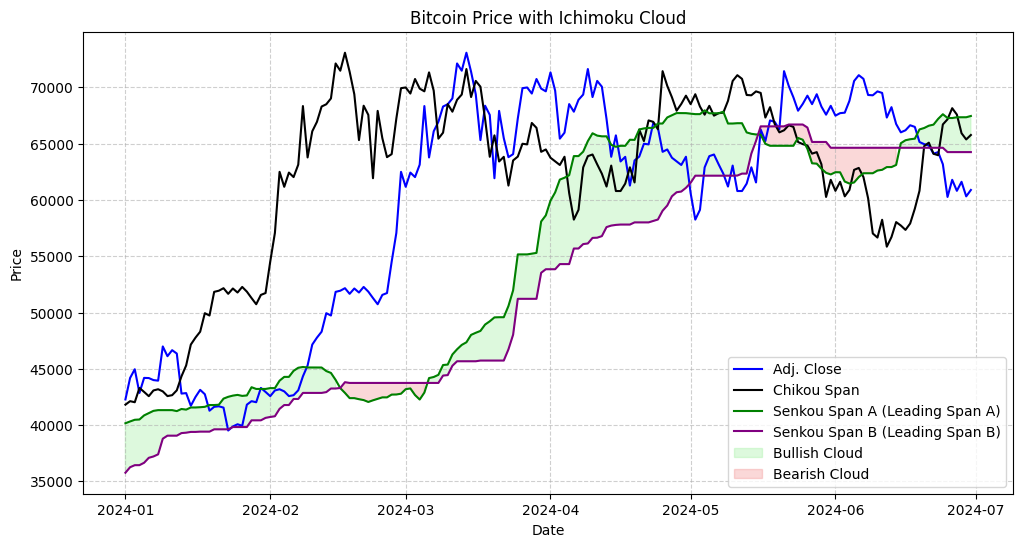

In [ ]:
#Visualization
df = crypto_data['BTC-USD'].loc[start_date:end_date]
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Adj. Close'], label='Adj. Close', color='blue')
plt.plot(df.index, df['Chikou_Span'], label='Chikou Span', color='black')
plt.plot(df.index, df['Senkou_Span_A'], label='Senkou Span A (Leading Span A)', color='green', linestyle='solid')
plt.plot(df.index, df['Senkou_Span_B'], label='Senkou Span B (Leading Span B)', color='purple', linestyle='solid')
plt.fill_between(df.index, df['Senkou_Span_A'], df['Senkou_Span_B'],
                 where=df['Senkou_Span_A'] >= df['Senkou_Span_B'], color='lightgreen', alpha=0.3, label='Bullish Cloud')
plt.fill_between(df.index, df['Senkou_Span_A'], df['Senkou_Span_B'],
                 where=df['Senkou_Span_A'] < df['Senkou_Span_B'], color='lightcoral', alpha=0.3, label='Bearish Cloud')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price with Ichimoku Cloud')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

##### Commodity Channel Index

***What:***
- It is a momentum-based indicator that measures how far the current price deviates from its historical average.
- It helps identify overbought and oversold conditions, as well as trend strength and reversals.

***Interpretation:***

* CCI Above +100 → Strong bullish momentum (overbought signal).

* CCI Below -100 → Strong bearish momentum (oversold signal).

* CCI Crosses Above 0 → Possible start of an uptrend.

* CCI Crosses Below 0 → Possible start of a downtrend.

#### Missing Values Removal

Rows with NaN values are dropped, to remove incomplete data, which arises from the calculation of new variables (e.g.,Moving Averages), ensuring that only fully computed rows remain for analysis.

In [12]:
for ticker in cryptos:
    # Dropping rows with NaN values
    crypto_data[ticker].dropna(inplace=True)

    # Reset the index after dropping rows
    crypto_data[ticker].reset_index(inplace=True)

    # Drop the 'Volume' and 'Date' columns
    crypto_data[ticker].drop(['Volume', 'Date'], axis=1, inplace=True)

In [13]:
# Check
for ticker in crypto_data:
  print(f"Showing data for {ticker}:")
  display(crypto_data[ticker].head())
  print(crypto_data[ticker].shape)

Showing data for ETH-USD:


,Open,High,Low,Adj. Close,RSI,EMAF,EMAM,EMAS,Bollinger_Lower,Bollinger_Middle,...,AO,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI,Target,Pct Return,TargetClass
0,559.590027,583.135986,545.431030,566.830017,40.227891,632.786367,713.403778,762.737699,526.054719,656.126450,...,-115.731866,606.764008,673.804504,650.527237,583.775482,455.936005,-99.388875,-8.333008,-0.014701,0
1,577.645020,585.538025,557.065979,558.497009,39.362112,625.711190,710.336318,760.032524,515.277088,647.700650,...,-117.656402,582.093994,673.804504,671.582253,595.630005,460.733002,-86.000134,20.174988,0.036124,1
2,580.043030,589.093018,567.664978,578.671997,42.568420,621.231267,707.729103,757.630398,507.809014,642.640399,...,-114.662800,564.868988,654.154999,680.031250,599.431000,432.243988,-66.001770,1.757019,0.003036,2
3,591.807983,597.077026,577.322021,580.429016,42.850388,617.345338,705.208310,755.283360,501.498311,637.303101,...,-103.231968,564.868988,643.400513,681.266747,599.431000,442.290009,-53.586074,10.829956,0.018659,1
4,618.328979,624.513000,591.258972,591.258972,44.645199,614.860922,702.951887,753.110851,500.439447,630.229401,...,-88.366792,568.532501,639.649994,697.578247,599.431000,422.587006,-30.025854,28.178040,0.047658,1


(2382, 26)
Showing data for BTC-USD:


,Open,High,Low,Adj. Close,RSI,EMAF,EMAM,EMAS,Bollinger_Lower,Bollinger_Middle,...,AO,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI,Target,Pct Return,TargetClass
0,7406.520020,7573.770020,7313.600098,7469.729980,38.082936,7996.986391,9124.682402,9690.242041,7011.276832,8092.447583,...,-1221.677387,7756.965088,8527.590088,8746.435059,8162.600098,6171.970215,-86.059348,-63.580078,-0.008512,0
1,7494.169922,7608.899902,7361.129883,7406.149902,37.274777,7940.716249,9090.652056,9659.989165,6984.683044,8010.107080,...,-1169.212881,7572.670166,8515.409912,8881.049927,8245.685059,6253.549805,-75.697772,94.550293,0.012766,1
2,7541.450195,7604.729980,7407.339844,7500.700195,39.326280,7898.809958,9059.167861,9631.389311,6934.802634,7963.070068,...,-1084.275767,7414.640137,8378.264893,8906.639893,8245.685059,6084.399902,-62.261263,36.020020,0.004802,2
3,7643.450195,7695.830078,7497.259766,7536.720215,40.125590,7864.325221,9029.020383,9603.645350,6902.659749,7914.131567,...,-965.017977,7393.255127,8276.715088,8906.639893,8245.685059,6153.160156,-46.655845,95.369629,0.012654,1
4,7720.250000,7754.890137,7613.040039,7632.089844,42.282595,7842.207566,9001.358392,9577.532032,6911.593367,7860.081079,...,-841.758219,7422.785156,8243.360107,9144.744995,8245.685059,5898.129883,-28.058584,90.439941,0.011850,1


(2382, 26)
Showing data for USDT-USD:


,Open,High,Low,Adj. Close,RSI,EMAF,EMAM,EMAS,Bollinger_Lower,Bollinger_Middle,...,AO,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI,Target,Pct Return,TargetClass
0,0.999727,1.00982,0.995158,0.999487,48.247499,1.000661,1.000789,1.001181,0.998404,1.001098,...,-0.001786,0.998453,1.001123,1.002167,1.000226,1.004870,39.253593,0.002513,0.002514,1
1,0.998003,1.00748,0.994691,1.002000,52.176888,1.000788,1.000813,1.001192,0.998626,1.000994,...,-0.000704,0.998453,1.001123,1.002167,1.000226,0.998834,30.340994,-0.002912,-0.002906,0
2,1.000990,1.00865,0.994694,0.999088,47.682089,1.000626,1.000779,1.001164,0.998507,1.000961,...,-0.000261,0.998453,1.001123,1.002167,1.000226,1.002390,-2.703983,0.001092,0.001093,1
3,0.993530,1.00564,0.986231,1.000180,49.432371,1.000584,1.000767,1.001151,0.998476,1.000945,...,-0.000686,0.998453,1.001123,1.002126,1.000226,0.998823,-177.296099,-0.008150,-0.008149,0
4,1.000100,1.00376,0.986847,0.992030,38.999435,0.999769,1.000594,1.001030,0.995888,1.000448,...,-0.000962,0.996817,1.001123,1.001004,1.000226,0.996047,-253.022802,0.005684,0.005730,1


(2382, 26)
Showing data for DOGE-USD:


,Open,High,Low,Adj. Close,RSI,EMAF,EMAM,EMAS,Bollinger_Lower,Bollinger_Middle,...,AO,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI,Target,Pct Return,TargetClass
0,0.003354,0.003506,0.003323,0.003447,37.190213,0.003961,0.005097,0.005621,0.003071,0.004035,...,-0.001074,0.003724,0.004262,0.004829,0.004277,0.002490,-93.725137,-0.000018,-0.005222,2
1,0.003398,0.003513,0.003317,0.003429,36.940110,0.003911,0.005064,0.005592,0.003073,0.003954,...,-0.001032,0.003721,0.004262,0.004834,0.004277,0.002501,-84.148077,-0.000002,-0.000583,2
2,0.003423,0.003469,0.003336,0.003427,36.910560,0.003865,0.005032,0.005563,0.003024,0.003903,...,-0.000979,0.003441,0.004262,0.004836,0.004277,0.002484,-76.951219,-0.000009,-0.002626,2
3,0.003558,0.003584,0.003400,0.003418,36.768744,0.003822,0.005000,0.005535,0.002976,0.003859,...,-0.000891,0.003387,0.004262,0.004874,0.004277,0.002406,-61.267353,0.000158,0.046226,1
4,0.003690,0.003750,0.003545,0.003576,41.030366,0.003799,0.004972,0.005509,0.002974,0.003812,...,-0.000774,0.003459,0.004246,0.004997,0.004277,0.002409,-30.575706,0.000115,0.032159,1


(2382, 26)


- Total observations are 2382.
- It amounts to ~6 years of historical data.
- After data cleaning, just ~0.06% of initial observations was removed.


## Descriptive Statistics and Data Visualization

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Function to compute descriptive statistics
def descriptive_statistics(crypto_data, cryptos):
    for ticker in cryptos:
        df = crypto_data[ticker][var]

        print(f"Descriptive Statistics for {ticker}:")

        # 1. Central Tendency: Mean, Median, Mode
        mean = df.mean()
        median = df.median()
        mode = df.mode().iloc[0]  # Mode might return multiple, take the first one

        print(f"Mean for {ticker}:")
        print(mean)
        print(f"Median for {ticker}:")
        print(median)
        print(f"Mode for {ticker}:")
        print(mode)

        # 2. Dispersion: Standard Deviation, Variance, Range, IQR
        std_dev = df.std()
        variance = df.var()
        data_range = df.max() - df.min()
        iqr = df.quantile(0.75) - df.quantile(0.25)

        print(f"Standard Deviation for {ticker}:")
        print(std_dev)
        print(f"Variance for {ticker}:")
        print(variance)
        print(f"Range for {ticker}:")
        print(data_range)
        print(f"Interquartile Range (IQR) for {ticker}:")
        print(iqr)

        # 3. Shape of the Distribution: Skewness, Kurtosis
        skewness = df.skew()
        kurtosis = df.kurtosis()

        print(f"Skewness for {ticker}:")
        print(skewness)
        print(f"Kurtosis for {ticker}:")
        print(kurtosis)

        # 4. Quantiles: Min, 25th percentile (Q1), Median (Q2), 75th percentile (Q3), Max
        quantiles = df.quantile([0.25, 0.50, 0.75, 1.0])

        print(f"Quantiles for {ticker}:")
        print(quantiles)

        # 5. Correlation: Pearson Correlation Coefficients
        correlation = df.corr()

        print(f"Correlation matrix for {ticker}:")
        print(correlation)

        # 6. Visualizations: Histograms, Boxplots, Correlation Heatmap
        # Histogram of all numerical columns
        df.hist(bins=50, figsize=(15, 10))
        plt.suptitle(f"Histogram for {ticker}")
        plt.show()

        # Boxplot of all numerical columns
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df)
        plt.title(f"Boxplot for {ticker}")
        plt.show()

        # Heatmap of the correlation matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f"Correlation Heatmap for {ticker}")
        plt.show()

# Call the function with the crypto_data dictionary
descriptive_statistics(crypto_data, cryptos)


Descriptive Statistics for ETH-USD:
Mean for ETH-USD:
0.0017873826690832306
Median for ETH-USD:
0.0007162443313470342
Mode for ETH-USD:
-0.42132782914825656
Standard Deviation for ETH-USD:
0.04411070391979743
Variance for ETH-USD:
0.0019457542003000318
Range for ETH-USD:
0.6828435173471457
Interquartile Range (IQR) for ETH-USD:
0.03988760929301917
Skewness for ETH-USD:
-0.26251712936673505
Kurtosis for ETH-USD:
7.215479473110575
Quantiles for ETH-USD:
0.25   -0.018067
0.50    0.000716
0.75    0.021821
1.00    0.261516
Name: Pct Return, dtype: float64


TypeError: Series.corr() missing 1 required positional argument: 'other'

1. **For BTC - DOGE - ETH:**
  
  **High Correlation Among Certain Features (Open, High, Low, Adj. Close, EMAF, EMAM, EMAS and other technical indicators)**
- Perfect or High Correlation:
    - Open being highly correlated (almost perfectly) with High, Low, Adj. Close, EMAF, EMAM, EMAS makes sense because they are related to each other.

  - Open, High, Low, and Adj. Close are fundamental price metrics, and they are directly related to each other within a trading session. For example:

  - High and Low represent the highest and lowest prices during a day (which are influenced by the opening price).
  - Adj. Close is derived from the Closing price, which often depends on open prices and overall market conditions during the trading session.
  - EMAF, EMAM, and EMAS (Exponential Moving Averages) are smoothing indicators of past prices, which are also dependent on the same underlying price data (Open, Close, High, Low).

We might decide to drop them.

**Low Correlation with Target Variables (Target, Target Class, Pct Return)**

These variables represent future price movement, which is not directly tied to current price data.

The target variables are based on price changes, so naturally, they are less correlated with the current prices.

This is good news because we want the model to predict predict future price movement based on trends and patterns.

**Very Low Correlation with RSI**

RSI (Relative Strength Index) is very little correlated with Open, High, Low, Adj. Close.

RSI is a momentum oscillator and not directly related to price levels.
It captures whether an asset is overbought or oversold, so it will not necessarily have a high correlation with absolute price values.
Instead, it focuses on price movement direction and velocity.

This low correlation suggests that  RSI indicator is adding a distinct and potentially valuable signal to the model. It is a good sign.

**2. For USDT:**

- Correlation between Adjusted Close and features like High and Low is moderate compared to other cryptos, as USDT price stability minimizes deviations between these values.

- Volatility and momentum-based indicators (e.g., RSI, Bollinger Bands, AO) are less applicable due to the predictable nature of USDT pricing.



## Feature Selection


Due to the high dimensional feature space and the high correlation between some indicators, feature selection is fondamental for:
* Reducing dimensionality
* Eliminating irrelevant or redundant features to reduce overfitting
* Improving model generalization

We decide to use **RandomForest as model for feature selection** for multiple reason:

1. Elastic Net combines LASSO (L1 regularization) and Ridge (L2 regularization) were not adequate:
  - They are commonly used for feature selection in linear or logistic regression models.
  - Finanacial timeseries, especially in crypto market do not follow neither a linear pattern nor a logistic one.
  - Elastic Net might favor features that have a linear correlation with the target variable while ignoring complex, non-linear interactions that might be more relevant.

2.  Principal Component Analysis (PCA) was not adequate:
  - It is often applied in Random Forest models to improve efficiency
  - PCA transforms the original features into a set of uncorrelated components, effectively removing the time-dependent structure of the data.
  - For the purpose of analysis, time dependencies are fundamental to identify time-pattern (f.e., in LSMT), such transformations would reduce the ability of the model to capture such patterns.

3. **Random Forest** provides a reliable measure of feature importance
  - It doesn't assume linearity, capturing also **non-linear relationships**.
  - It **retains time-series dependencies**.
  - It allows **filtering out weak features**


For feature selection in the Random Forest Classifier, we use **Gini Importance**.

**Strategy for Selecting Features:**

- Split data into training and testing sets (e.g., 80% train, 20% test).
- Train classifier model.
- Check the feature importance provided by the model (using .feature_importances_.) and check accuracy.
- Drop low-importance features (25th percentile of importance's distribution).
- After we’ve selected the most important features, hyperparameter tuning will be performed.

In [ ]:
!pip install sklearn.model_selection

ERROR: Could not find a version that satisfies the requirement sklearn.model_selection (from versions: none)
ERROR: No matching distribution found for sklearn.model_selection


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Create a variable containing predictors (X)
predictors = crypto_data['BTC-USD'].columns.tolist()
predictors.remove('Target')
predictors.remove('TargetClass')
predictors.remove('Pct Return')

# Divide into train and test; Store into 2 separate dictionaries
train = {}
test = {}
for ticker in cryptos:
  train[ticker], test[ticker] = train_test_split(crypto_data[ticker], train_size=0.8, random_state=42)

# Define model; Baseline model: no hyperparamether tuning;
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model: the purpose is to detect feature importance
importance = {}

for ticker in cryptos:
  model.fit(train[ticker].iloc[:, range(len(predictors))], train[ticker]['TargetClass'])
  importance[ticker] = model.feature_importances_

# Visualization of importance
df_importance = pd.DataFrame(importance, index = predictors)
df_importance


,ETH-USD,BTC-USD,USDT-USD,DOGE-USD
Open,0.080238,0.078144,0.131787,0.080491
High,0.050646,0.051431,0.071144,0.056475
Low,0.052713,0.050588,0.054464,0.049507
Adj. Close,0.064399,0.067699,0.107315,0.068770
RSI,0.071317,0.071534,0.082029,0.068888
EMAF,0.041274,0.040327,0.040719,0.040060
EMAM,0.041818,0.042804,0.033905,0.040863
EMAS,0.041930,0.044803,0.039623,0.041786
Bollinger_Lower,0.049057,0.047237,0.034503,0.044649
Bollinger_Middle,0.039231,0.038080,0.030616,0.039355


- Many features display a very irrelevant contribution to the model's decision making.

- For each cryptocurrency dataset:
  - The feature importance scores were analyzed.
  - The features that had importance scores **lower than the 25th percentile were removed**, keeping only the more impactful ones.

In [ ]:
# Create dictionary with a new set of features; Selected on 'Importance distribution' for each crypto (>25th percentile)
filtered_importance = {}

for ticker in cryptos:
  threshold = np.percentile(np.array(df_importance[ticker]), 25 )
  filtered_importance[ticker] = df_importance[ticker].apply(lambda x: x if x > threshold else np.nan)
  filtered_importance[ticker] = filtered_importance[ticker].dropna()

  print(f"Filtered Importance for {ticker}:")
  print(filtered_importance[ticker])

Filtered Importance for ETH-USD:
Open                0.080238
High                0.050646
Low                 0.052713
Adj. Close          0.064399
RSI                 0.071317
EMAF                0.041274
EMAM                0.041818
EMAS                0.041930
Bollinger_Lower     0.049057
Bollinger_Middle    0.039231
Bollinger_Upper     0.044037
AO                  0.053233
Tenkan_Sen          0.034030
Senkou_Span_A       0.041727
Senkou_Span_B       0.029245
Chikou_Span         0.055765
CCI                 0.068410
Name: ETH-USD, dtype: float64
Filtered Importance for BTC-USD:
Open                0.078144
High                0.051431
Low                 0.050588
Adj. Close          0.067699
RSI                 0.071534
EMAF                0.040327
EMAM                0.042804
EMAS                0.044803
Bollinger_Lower     0.047237
Bollinger_Middle    0.038080
Bollinger_Upper     0.042965
AO                  0.056231
Tenkan_Sen          0.033043
Senkou_Span_A       0.041353
Senko

In [ ]:
# Make predictions & Calculate Accuracy on model with new features
predictions_f = {}
accuracy_f={}

for ticker in cryptos:
  col = pd.DataFrame(filtered_importance[ticker]).index
  print(f"Selected Features for {ticker}: {col}")
  model.fit(train[ticker][col], train[ticker]['TargetClass'])
  predictions_f[ticker] = model.predict(test[ticker][col])

  accuracy_f[ticker] = model.score(test[ticker][col], test[ticker]['TargetClass'])
  print(f"Accuracy for {ticker}: {accuracy_f[ticker]:.4f}")

Selected Features for ETH-USD: Index(['Open', 'High', 'Low', 'Adj. Close', 'RSI', 'EMAF', 'EMAM', 'EMAS',
       'Bollinger_Lower', 'Bollinger_Middle', 'Bollinger_Upper', 'AO',
       'Tenkan_Sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', 'CCI'],
      dtype='object')
Accuracy for ETH-USD: 0.4340
Selected Features for BTC-USD: Index(['Open', 'High', 'Low', 'Adj. Close', 'RSI', 'EMAF', 'EMAM', 'EMAS',
       'Bollinger_Lower', 'Bollinger_Middle', 'Bollinger_Upper', 'AO',
       'Tenkan_Sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', 'CCI'],
      dtype='object')
Accuracy for BTC-USD: 0.4801
Selected Features for USDT-USD: Index(['Open', 'High', 'Low', 'Adj. Close', 'RSI', 'EMAF', 'EMAM', 'EMAS',
       'Bollinger_Lower', 'Bollinger_Middle', 'Bollinger_Upper', 'Fib_0.236',
       'Fib_0.382', 'Fib_0.786', 'AO', 'Chikou_Span', 'CCI'],
      dtype='object')
Accuracy for USDT-USD: 0.7589
Selected Features for DOGE-USD: Index(['Open', 'High', 'Low', 'Adj. Close', 'RSI', 'EMAF'

- We notice suspiciously **high levels of accuracy**.

- This is a sign of possible overfitting.

- They will be further analyzed in the section dedicated to 'Hyperparameter Tuning' for the Random Forest Classifier.

- For the purpose of this section, we only focused on **removing irrelevant features.**

## Linear Regression and Polynomial Regression

We first explored a regression-based approach.

The models **predict** daily **price differences** as a continuous variable.

This might seem unrelated to the ultimate goal of classifying returns into categories (up, down, neutral), but this step serves an important purpose in our analysis.


**Why Regression?**
- Models as a baseline for classification: these models can provide a starting point for analyzing how well a simple model captures the movement of crypto prices. It allows for a simple yet insightful sense of whether price movements follow a predictable pattern (unlikely) or if they are characterized by noise.

- Demonstrate the Complexity of Price Movements: linear models struggle to capture the true nature of price movements, complex and volatile. Their implementation serves as justification for the use of our following models.

- Highlight the risk of Overfitting: linear models, especially polynomial regressions, make really clear the effect of overfitting. These experiments lead us to consider classification-based models.

- Visual Comparison: these models were also included to provide a clear, yet intuitive way to see how they try to follow the target variable, simply by memorizing also then noise and consequently loosing the capability of generalizing.

### Simple Linear Regression

The model predicts the absolute price difference (target variable) based on a time sequence (represented by X, which is simply a scaled index of the data).

Our approach:
- **X** is created as a sequence of numbers representing time, from 0 to 1, scaled by the total length of the data. Essentially, this transforms the time index into a normalized value between 0 and 1, **creating a temporal feature** for prediction.
- MinMaxScaler is used to scale the target (y) between 0 and 1.

{'ETH-USD'} Datasets :
Train error: 0.003
Test error: 0.003
Train R^2: 2.1654955538741305e-06
Test R^2: -0.0017733490372979777
Intercept:  [0.61523121]
Coefficents [Slope] [[-0.00032783]]


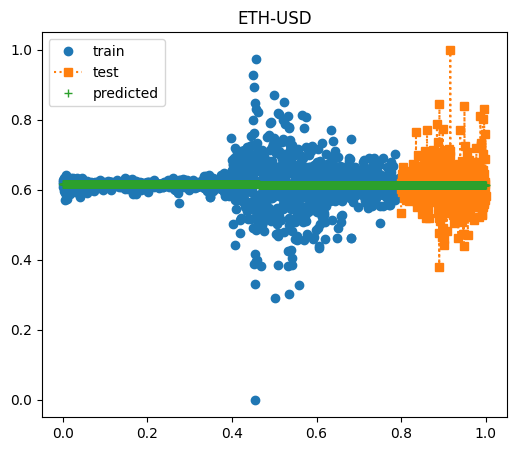

----------------------------------------
{'BTC-USD'} Datasets :
Train error: 0.004
Test error: 0.011
Train R^2: 4.793139948489067e-05
Test R^2: -0.008807668844230454
Intercept:  [0.46027157]
Coefficents [Slope] [[-0.00197076]]


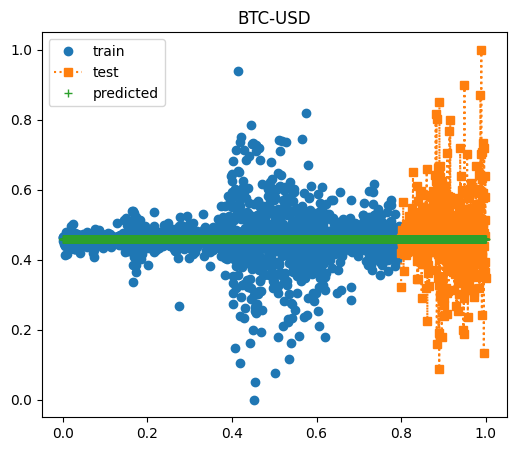

----------------------------------------
{'USDT-USD'} Datasets :
Train error: 0.002
Test error: 0.000
Train R^2: 1.2917120753019873e-06
Test R^2: -0.001200598948256415
Intercept:  [0.49047907]
Coefficents [Slope] [[-0.00020185]]


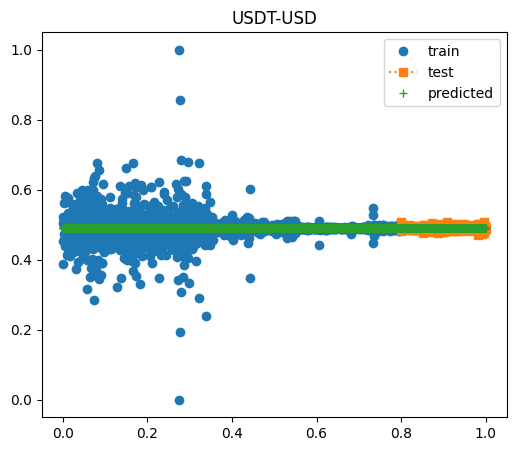

----------------------------------------
{'DOGE-USD'} Datasets :
Train error: 0.001
Test error: 0.001
Train R^2: 2.5258349490075993e-05
Test R^2: -0.010457298819203986
Intercept:  [0.44246647]
Coefficents [Slope] [[-0.00079095]]


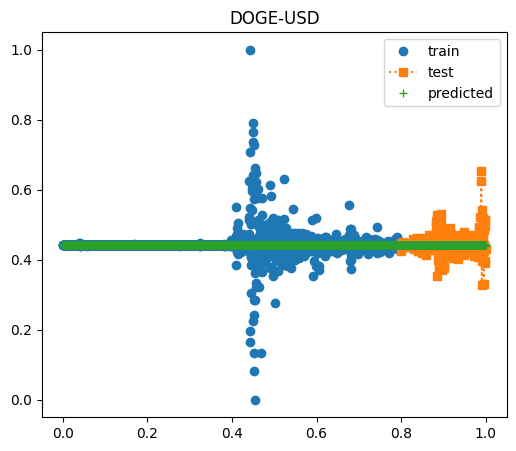

----------------------------------------


In [ ]:
# Simple Linear Regression: y= price difference;x = time; plot= scaled timeseries;
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def train_test(X, y, size=0.8):
    train_size = int(len(X) * size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test


for ticker in cryptos:
    df = crypto_data[ticker]
    X = np.arange(len(df), dtype=np.float64) / len(df)
    y = np.array(df['Target'])

    sc = MinMaxScaler(feature_range=(0, 1))
    X = X.reshape((len(X)), 1)
    y = sc.fit_transform(y.reshape(len(y), 1))

    X_train, X_test, y_train, y_test = train_test(X, y, size=0.8)

    model = LinearRegression(fit_intercept = True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X)

    print({ticker}, "Datasets :")

    # Calculate RMSE
    print("Train error: {:.3f}".format(mean_squared_error(y_train, y_pred[:int(len(df) * .8)])))
    print("Test error: {:.3f}".format(mean_squared_error(y_test, y_pred[int(len(df) * .8):])))

    print('Train R^2:', r2_score(y_train, y_pred[:int(len(df) * .8)]))
    print('Test R^2:' , r2_score(y_test, y_pred[int(len(df) * .8):]))
    print("Intercept: ", model.intercept_)
    print("Coefficents [Slope]" , model.coef_)
    fig, ax = plt.subplots(figsize = (6,5))
    ax.plot(X_train, y_train, 'o', label = 'train')
    ax.plot(X_test, y_test, 's:', label = 'test')
    ax.plot(X, y_pred, '+', label = 'predicted')
    ax.title.set_text(ticker)
    ax.legend()
    plt.show()
    print("-" * 40)


- **Low R² and High Error**:
  - The linear regression model is not explaining much of the variance in the target variable. As cleraly seen in negative values of R².

- **Overfitting**:
 - The model shows signs of overfitting, where the model fits well on training data but performs poorly on testing data, higher MSE in the test set .

- **Small Slope:**
  - The coefficients (slopes) are quite small, indicating that time (X) has a very limited effect on predicting the price difference.

### Polynomial Regression

 In this section, a Polynomial Regression to predict the price difference (target variable) of various cryptocurrencies is performed, using polynomial features derived from time-based data.

Our approach:
- For various degrees of **polynomial features (from 2 to 100)**, the model is trained and evaluated.
- Polynomial features are created for the independent variable (X)
- **Linear Regression model is trained** using these transformed features.
- We then make predictions and calculate the **Mean Squared Error (MSE)** for both the training and testing datasets.

{'ETH-USD'} Datasets :
Polynomial degree: 2
Train error: 0.003
Test error: 0.003
****************************************
Polynomial degree: 4
Train error: 0.003
Test error: 0.004
****************************************
Polynomial degree: 6
Train error: 0.003
Test error: 0.044
****************************************
Polynomial degree: 8
Train error: 0.003
Test error: 0.010
****************************************
Polynomial degree: 16
Train error: 0.003
Test error: 6160.736
****************************************
Polynomial degree: 32
Train error: 0.003
Test error: 70544146524.207
****************************************
Polynomial degree: 64
Train error: 0.003
Test error: 4005675197133610.000
****************************************
Polynomial degree: 100
Train error: 0.003
Test error: 71702002733302336.000
****************************************
{'BTC-USD'} Datasets :
Polynomial degree: 2
Train error: 0.004
Test error: 0.011
****************************************
Polynomial deg

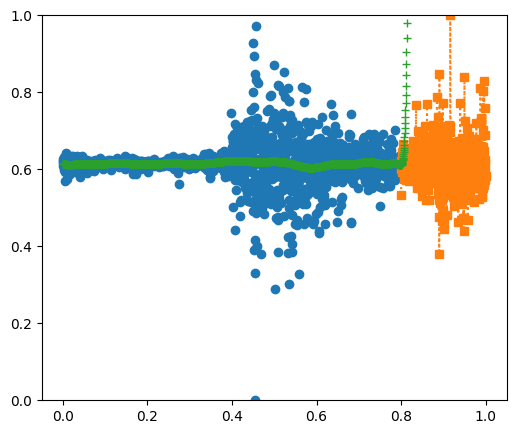

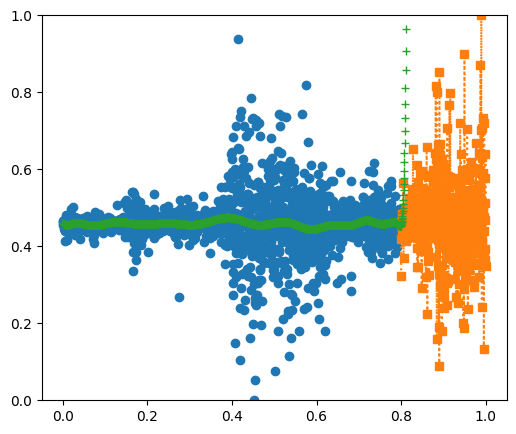

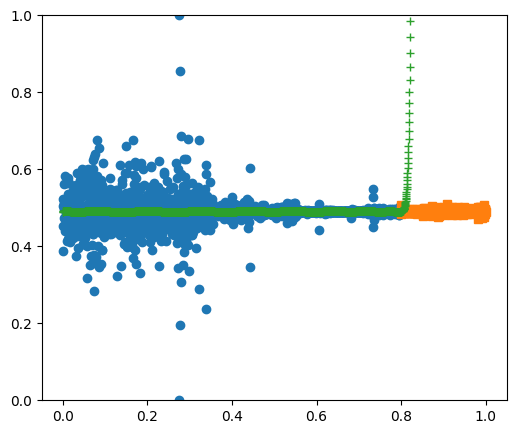

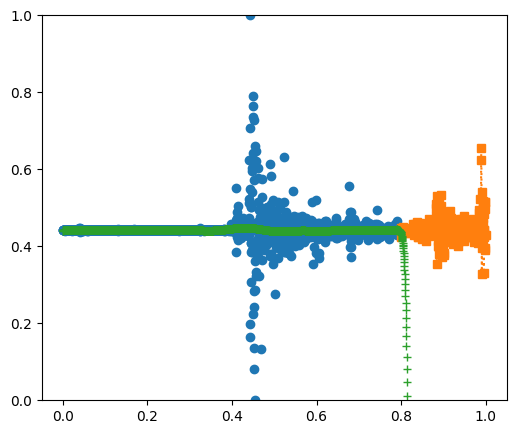

In [ ]:
# Polynomial Regression: different poly degrees; plot for 100 degrees
from sklearn.preprocessing import PolynomialFeatures

def train_test(X, y, size = .8):
    train_size = int(len(X) * size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

def X_y(df):
  X = np.arange(len(df), dtype = np.float64)/len(df)
  y = np.array(df["Target"])
  sc = MinMaxScaler(feature_range = (0,1))
  X = X.reshape(len(X), 1)
  y = sc.fit_transform(y.reshape(len(y),1))
  return X, y

for ticker in cryptos:
  X, y = X_y(crypto_data[ticker])
  X_train, X_test, y_train, y_test = train_test(X, y)
  print({ticker}, "Datasets :")
  for d in [2, 4, 6, 8, 16, 32, 64, 100]:
    poly = PolynomialFeatures(degree = d)
    poly.fit(X_train)
    X_train_poly = poly.transform(X_train)

    model = LinearRegression(fit_intercept = True)
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(poly.transform(X))

    print("Polynomial degree:", d)
    print("Train error: {:.3f}".format(mean_squared_error(y_train, y_pred[:len(X_train)])))
    print("Test error: {:.3f}".format(mean_squared_error(y_test, y_pred[len(X_train):])))
    print("*" * 40)
  fig, ax = plt.subplots(figsize = (6,5))
  ax.plot(X_train, y_train, "o", label = "train")
  ax.plot(X_test, y_test, "s:", label = "test")
  ax.plot(X, y_pred, "+", label = "predicted")
  ax.set_ylim(0, 1)

- For most cases, polynomial degrees between 2 and 8 seem to offer a good trade-off between model complexity and generalization.
- Higher polynomial degrees (16 and above) lead to overfitting, where the model captures more noise than useful patterns.

Note:
- Error values are not a reliable indicator of predictive power in this case
  - The model’s **simplicity** and use of **scaled data** mean that the errors are **misleadingly low**.
  - The polynomial regression is used here only for demonstrating how easily a model can overfit when simple features are used.

### Multiple Linear Regression

This Multiple Linear Regression predicts the price difference (target variable) of various cryptocurrencies using past data (features) as predictors.

Our approach:
- **Addresses Multicollinearity** by excluding highly correlated features to ensure more stable and interpretable model coefficients.
- **Maintains Time Order** for a more realistic financial model, ensuring predictions are made using past data only.
- **Evaluates Model Performance** using **RMSE and R²**, providing a clear understanding of model accuracy and generalization.
- **Visualizes Predictions** to intuitively compare actual vs. predicted trends, aiding in performance evaluation.

ETH-USD - Multiple Linear Regression Results:
Train RMSE: 64.4321 | Test RMSE: 75.5992
Train R²: 0.3332 | Test R²: 0.2882
Intercept: 86.18953820101518
Coefficients: [-0.38950032 -1.76221649 -2.13196028  0.34153372 -0.20217646  0.32786134
  0.3198186   0.31177586  0.07842958  0.04955867  0.02622465  0.00289062
 -0.0303307   0.36296664  0.74205005  0.31905116  0.26533371 -0.06589428
  0.03473579  0.25878863]


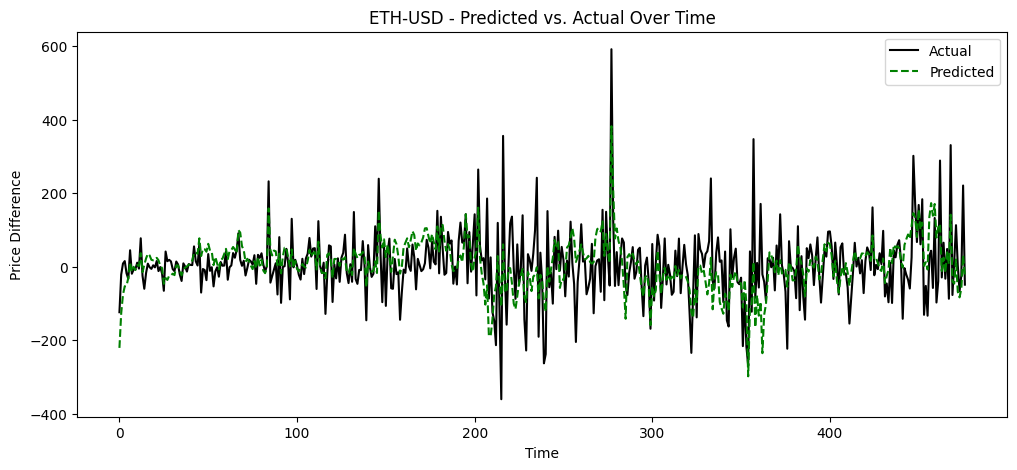

----------------------------------------
BTC-USD - Multiple Linear Regression Results:
Train RMSE: 818.2320 | Test RMSE: 1334.0173
Train R²: 0.3302 | Test R²: 0.2835
Intercept: 1071.193968281342
Coefficients: [-3.55063219e-01 -2.18469954e+01 -2.30262741e+00  3.14203594e-01
 -1.89486720e-01  4.02934292e-01  4.20934804e-01  4.38935317e-01
 -1.64782074e-02 -2.43676098e-02 -3.07439761e-02 -3.71203424e-02
 -4.61985589e-02  3.97687478e-01  7.43947420e-01  4.33565761e-01
  2.71884454e-01 -5.48455033e-02  2.77158561e-02  3.45468927e+00]


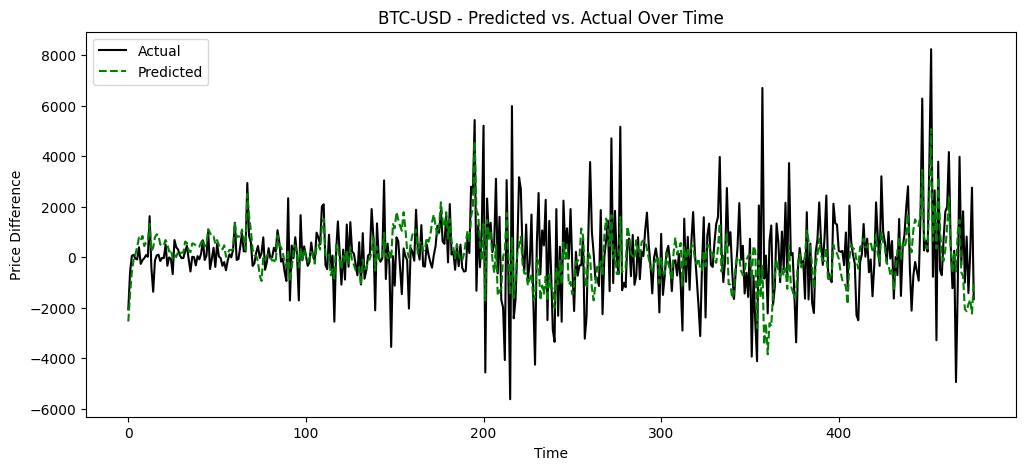

----------------------------------------
USDT-USD - Multiple Linear Regression Results:
Train RMSE: 0.0027 | Test RMSE: 0.0004
Train R²: 0.3346 | Test R²: -0.2530
Intercept: 0.2129921037163341
Coefficients: [-6.60966357e-01 -1.16211236e-04  2.88537262e-02  1.91894283e-01
 -2.39352648e-01  6.77980211e-02  1.26698353e-01  1.85598685e-01
 -9.49217989e-03  7.71541202e-04  9.06687743e-03  1.73622137e-02
  2.91725229e-02  3.43712081e-01  3.35849096e-02 -9.09882226e-03
  2.27537324e-02 -6.89970479e-03  5.13809167e-03  8.26974600e-06]


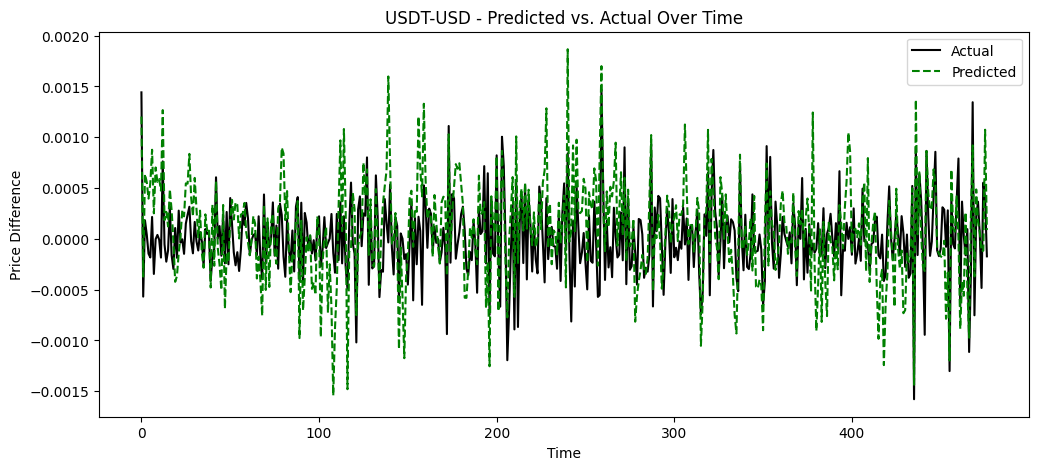

----------------------------------------
DOGE-USD - Multiple Linear Regression Results:
Train RMSE: 0.0096 | Test RMSE: 0.0091
Train R²: 0.3679 | Test R²: -0.1401
Intercept: 0.009971640524188457
Coefficients: [-4.90620782e-01 -1.93700475e-04 -2.07779711e+00  7.07624500e-01
 -3.90374656e-01  4.10421270e-01  3.69550406e-01  3.28679542e-01
  7.37017644e-02  5.01481490e-02  3.11116654e-02  1.20751817e-02
 -1.50276085e-02  5.07155870e-01  5.75584923e-01  2.00133772e-01
  2.38742951e-01 -6.64316900e-02  1.32941060e-02  2.13656600e-05]


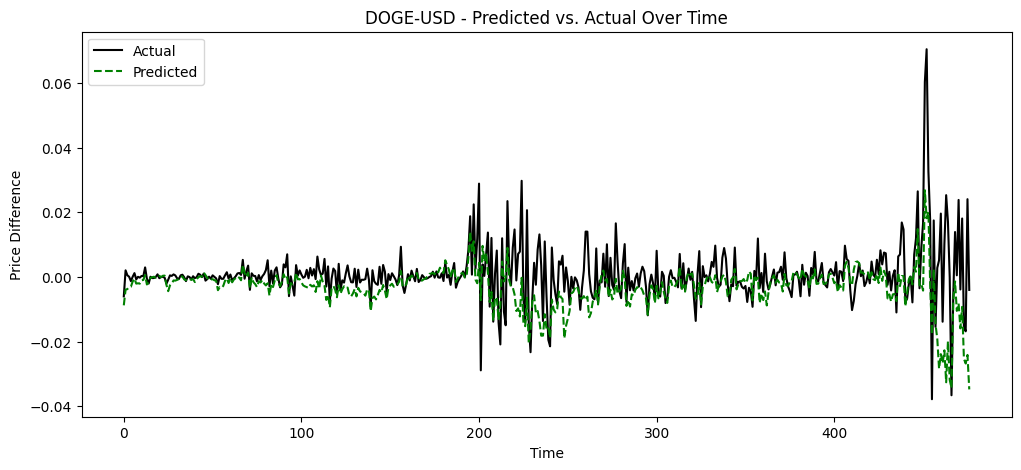

----------------------------------------


In [ ]:
# Multiple Linear Regression: y= price difference; x= predictors;
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


for ticker in cryptos:
  df = crypto_data[ticker].copy()

  # Define predictors (excluding target variables & highly correlated features to avoid data leakage)
  predictors = df.columns.tolist()
  predictors.remove('Target')
  predictors.remove('TargetClass')
  predictors.remove('Pct Return')
  predictors.remove('Open')
  predictors.remove('High')
  predictors.remove('Low')


  # Define X (features) and y (target)
  X = df[predictors].values  # Independent variables
  y = df['Target'].values     # Dependent variable

  # Train-test split (80% train, 20% test, keeping time order)
  split_idx = int(len(df) * 0.8)
  X_train, X_test = X[:split_idx], X[split_idx:]
  y_train, y_test = y[:split_idx], y[split_idx:]

  # Train the Linear Regression model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Make predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # Evaluate the model
  train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
  test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
  train_r2 = r2_score(y_train, y_train_pred)
  test_r2 = r2_score(y_test, y_test_pred)

  # Print results
  print(f"{ticker} - Multiple Linear Regression Results:")
  print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
  print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
  print(f"Intercept: {model.intercept_}")
  print(f"Coefficients: {model.coef_}")

  # Plot the results: Timeseries of Actual vs. Predicted
  plt.figure(figsize=(12, 5))
  plt.plot(range(len(y_test)), y_test, label="Actual", color='black')
  plt.plot(range(len(y_test)), y_test_pred, label="Predicted", color='green', linestyle="dashed")
  plt.xlabel("Time")
  plt.ylabel("Price Difference")
  plt.title(f"{ticker} - Predicted vs. Actual Over Time")
  plt.legend()
  plt.show()

  print(100 * '-')



- **Model Performance: Weak Predictive Power**
  - The R² values are low for both training and test sets (ranging from 0.28 to 0.36).
    - **Train R²: Around 0.33-0.37**. The model explains ~33-37% of the variation in price difference.
    - **Test R²: Around 0.28-0.28** for BTC and ETH, but **negative** for USDT and DOGE (meaning the model performs worse than just predicting the mean). It indicates a very weak generalization.

  - The **RMSE values are large**, especially for BTC (1334.01) and ETH (75.59), meaning large prediction errors.
- **Evidence of Overfitting**
  - **Train R² > Test R²** in all cases.

- **Feature Importance**
Looking at the coefficients, we see:
  - Some values are quite large (e.g., -21 for BTC, 3.45 for ETH).
  - Some features have tiny effects (e.g., AO, Fibonacci levels have coefficients near 0).
  - There is no clear dominant predictor that drives price movement.


The model struggles to capture price movements effectively, likely due to the limitations of the model to detect non-linear and complex market behaviors. The model overfits training data but generalizes poorly to unseen data.

## RNN - Long Short-Term Memory



### Model Selection
- LSTM (Long Short Term Memory) is modified version
of RNN (Recurrent Neural Network). RNN is best suitable
for stock price prediction as it can analyze **time-series
patterns.**
- The limitation of RNN is that it cannot save state
for long-term dependencies. In RNN, values are
backpropagated and slope becomes small which results in
vanishing gradient issue.
- LSTM overcomes this limitation by saving states in cell state.
- In LSTM the so called ***forget gate*** is available, which filters whether
previous state information is relevant or not.
    - If Forget gate output is 1, cell state saves the information
    - If output is 0, cell state ignores the information.
- Input and Output gates are also used in LSTM.

### Lookback Window for the RNN
Typical choices for price prediction models are:
- 30-90 days lookback: Captures short-term patterns.
- 180-365 days lookback: Captures yearly cycles & macro trends.

We will set a  **50** lookback window, a sort of compromise to capture both patterns.

Our code is scalable, therfore any change in the lookback window can be easily performed in the data preparation section.

### Data Preparation

Steps:
1. Define Predictors (X):

  - Extract the feature columns from the 'BTC-USD' dataset (it could be any crypto - BTC was chosen randomly).
  - Remove target variables.

2. Prepare Data for LSTM:

  - Create **Empty Dictionaries**: new dictionaries (X_dict, y_dict) store features and target values for each cryptocurrency.
  - Define **Lookback Period** (Backcandles): Set a time window of the last 50 data points to be used as input features for the LSTM model.
  - **Initialize features dictionary** (X): For each cryptocurrency, gather the past 50 time steps of features (predictors) and store them in a list (X_lstm).
  - **Initialize target dictionary** (y): For each cryptocurrency, assign the target variable (TargetClass) for each time step after the backcandles window.


3. Reshape Data for LSTM:

  - Adjust the shape of the feature array X_dict to match the expected format for LSTM models (time-steps as the first axis).
4. Select Important Features:

  - For each cryptocurrency, assign the most important predictors that were previously established; Using their column indices.

5. Split Data into Training and Testing:

  - Train-Test Split: Divide the data into training (80%) and testing (20%) sets. We **only include the important predictors** (columns) when creating X_train, X_test, y_train, and y_test.


In [ ]:
# Create a variable containing predictors (X)
predictors = crypto_data['BTC-USD'].columns.tolist()
predictors.remove('Target')
predictors.remove('TargetClass')
predictors.remove('Pct Return')

predictors

['Open',
 'High',
 'Low',
 'Adj. Close',
 'RSI',
 'EMAF',
 'EMAM',
 'EMAS',
 'Bollinger_Lower',
 'Bollinger_Middle',
 'Bollinger_Upper',
 'Fib_0.236',
 'Fib_0.382',
 'Fib_0.5',
 'Fib_0.618',
 'Fib_0.786',
 'AO',
 'Tenkan_Sen',
 'Kijun_Sen',
 'Senkou_Span_A',
 'Senkou_Span_B',
 'Chikou_Span',
 'CCI']

In [ ]:
# Creating dicionaries containing suitable time-series arrays for LSTM
X_dict = {}
y_dict =  {}
backcandles = 50

for ticker in cryptos:
  X_lstm = []
  y_lstm = []

  for i in range(len(predictors)):
    X_lstm.append([])
    for j in range(backcandles, len(crypto_data[ticker])):
      X_lstm[i].append(crypto_data[ticker].iloc[j - backcandles : j, i])

  for j in range(backcandles, len(crypto_data[ticker])):
    y_lstm.append(crypto_data[ticker]['TargetClass'].iloc[j])

  X_dict[ticker] = np.array(X_lstm)
  y_dict[ticker] = np.array(y_lstm)

  X_dict[ticker] = np.moveaxis(X_dict[ticker], [0], [2])
  print(X_dict[ticker].shape)
  print(y_dict[ticker].shape)

(2332, 50, 23)
(2332,)
(2332, 50, 23)
(2332,)
(2332, 50, 23)
(2332,)
(2332, 50, 23)
(2332,)


In [ ]:
# Get exact position index for each predictor
for ticker in cryptos:
  print(filtered_importance[ticker].index)
  col_indices = [crypto_data[ticker].columns.get_loc(col_name) for col_name in col]
  print(col_indices)

Index(['Open', 'High', 'Low', 'Adj. Close', 'RSI', 'EMAF', 'EMAM', 'EMAS',
       'Bollinger_Lower', 'Bollinger_Middle', 'Bollinger_Upper', 'AO',
       'Tenkan_Sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', 'CCI'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 21, 22]
Index(['Open', 'High', 'Low', 'Adj. Close', 'RSI', 'EMAF', 'EMAM', 'EMAS',
       'Bollinger_Lower', 'Bollinger_Middle', 'Bollinger_Upper', 'AO',
       'Tenkan_Sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', 'CCI'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 21, 22]
Index(['Open', 'High', 'Low', 'Adj. Close', 'RSI', 'EMAF', 'EMAM', 'EMAS',
       'Bollinger_Lower', 'Bollinger_Middle', 'Bollinger_Upper', 'Fib_0.236',
       'Fib_0.382', 'Fib_0.786', 'AO', 'Chikou_Span', 'CCI'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 21, 22]
Index(['Open', 'High', 'Low', 'Adj. Close', 'RSI', 'EMAF', 'EMAM', 'EMAS',
       'Bollinger_L

In [ ]:
# Check dimensions
for ticker in cryptos:
  print(X_dict[ticker].shape)

(2332, 50, 23)
(2332, 50, 23)
(2332, 50, 23)
(2332, 50, 23)


In [ ]:
# Divide dataset into train and test (80% train - 20% test)
X_train = {}
y_train = {}
X_test = {}
y_test = {}

for ticker in cryptos:
  size = .8
  col = filtered_importance[ticker].index
  col_indices = [crypto_data[ticker].columns.get_loc(col_name) for col_name in col]
  X_train[ticker] = X_dict[ticker][:, :, col_indices][:int(size*X_dict[ticker].shape[0])]
  y_train[ticker] = y_dict[ticker][:int(size*y_dict[ticker].shape[0])]
  X_test[ticker] = X_dict[ticker][:, :, col_indices][int(size*X_dict[ticker].shape[0]):]
  y_test[ticker] = y_dict[ticker][int(size*y_dict[ticker].shape[0]):]

In [ ]:
# Check for consistent dimensions after filtering
for ticker in cryptos:
  print(f'Dataset: {ticker}')
  print(X_train[ticker].shape)
  print(y_train[ticker].shape)
  print(X_test[ticker].shape)
  print(y_test[ticker].shape)

Dataset: ETH-USD
(1865, 50, 17)
(1865,)
(467, 50, 17)
(467,)
Dataset: BTC-USD
(1865, 50, 17)
(1865,)
(467, 50, 17)
(467,)
Dataset: USDT-USD
(1865, 50, 17)
(1865,)
(467, 50, 17)
(467,)
Dataset: DOGE-USD
(1865, 50, 17)
(1865,)
(467, 50, 17)
(467,)


### Bayesian Optimization & Model Training

**Model Definition (build_hyperLSTM):**

- Builds an LSTM model with a variable number of LSTM layers, units, and dropout rates.
- It optimizes for 3 hyperparameters: number of LSTM layers (layers), number of units per layer (units), and dropout rate (dropout).
- The final layer is a dense output layer with 3 units (for our task of classyfing into 3 levels) and a softmax activation.
- The model uses the Adam optimizer with a learning rate that can also be tuned.
- This model is designed to predict a categorical target (categorical_crossentropy loss).

**Hyperparameter Tuning:**

- Bayesian Optimization is used for hyperparameter search.
- The **search objective is val_accuracy**, meaning the tuner aims to maximize validation accuracy.
- The model's training is performed with early stopping to prevent overfitting.

**Training Loop:**

- For each cryptocurrency, the tuner runs a search for the best hyperparameters.
- It uses the X_train and y_train data, training for a set number of epochs with early stopping for each trial.
- The best hyperparameters for each cryptocurrency are used to train the final model.

In [ ]:
# Model definition

def build_hyperLSTM(hp):
  model = Sequential()

  layers = hp.Int('layers', min_value=1, max_value=3, step=1)
  units = hp.Choice('units', values = [32, 64, 128])
  model.add(LSTM(units, input_shape = (X_train[ticker].shape[1] , X_train[ticker].shape[2]), return_sequences = True))
  model.add(Activation('relu'))
  model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

  for i in range(1, layers):
    model.add(LSTM(units, return_sequences = True))
    model.add(Activation('relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

  model.add(LSTM(units, return_sequences = False))
  model.add(Activation('relu'))
  model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

  model.add(Dense(3, activation = 'softmax'))

  model.compile(
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

  return model

In [ ]:
!pip install tensorflow
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Definition of hyperparameter to be tuned
tuner = kt.BayesianOptimization(
    build_hyperLSTM,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'lstm_tuning',
    project_name = 'lstm_tuning_BayesanOptimization'
)

# Hyperparameter optimization: Bayesian Optimization; Model Fitting
best_models = {}
for ticker in cryptos:
  print(f'Tuning LSTM for: {ticker}')
  tuner.search(
        X_train[ticker], to_categorical(y_train[ticker], num_classes = 3),
        epochs = 10,
        batch_size = 32, validation_split = 0.2,
        callbacks=[early_stopping]
    )

  best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
  best_model = tuner.hypermodel.build(best_hps)

  best_model.fit(X_train[ticker], to_categorical(y_train[ticker], num_classes = 3),
        epochs=10, batch_size = 32,
        callbacks = [early_stopping], validation_split = 0.2
    )

  best_models[ticker] = best_model

Trial 10 Complete [00h 02m 51s]
val_accuracy: 0.3163538873195648

Best val_accuracy So Far: 0.4477211833000183
Total elapsed time: 00h 17m 25s
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.3257 - loss: 1.1094 - val_accuracy: 0.2895 - val_loss: 1.1250
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3712 - loss: 1.0986 - val_accuracy: 0.2735 - val_loss: 1.1293
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3633 - loss: 1.0943 - val_accuracy: 0.2735 - val_loss: 1.1308
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.3708 - loss: 1.0919 - val_accuracy: 0.2708 - val_loss: 1.1299
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3567 - loss: 1.1036 - val_accuracy: 0.2654 - val_loss: 1.1309
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3691 - loss: 1.0896 - val_accuracy: 0.2681 - val_loss: 1.1311
Tuning LSTM for: BTC-USD
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.2905 

Results:

**1. ETH:**
  
  - Drop in validation accuracy.
  - Training accuracy improves a bit, the validation accuracy decreases or stays constant
  - Potential overfitting or difficulty in capturing meaningful patterns.

**2. BTC:**
- Highest validation accuracy in the first epoch
- Starts to overfit as the epochs progress.
- The loss remains high, and the validation accuracy significantly drops.

**3. DOGE**
- Slight improvement in accuracy but doesn't achieve a high validation accuracy.

- **Trials and Best Performance:**
    - Trial 10 had a validation accuracy (val_accuracy) of 0.316.
    - The best val_accuracy so far (across all trials) is 0.447.

- **Validation Accuracy Fluctuations:**

  - Low Validation Accuracy: Across most of the trials, the model does not seem to perform well on the validation set, with validation accuracy often staying low or even decreasing. This suggests the model is not learning the undelying pattern.

- **Potential Overfitting**

- **Loss Values:** The loss values for both training and validation are high.  For a classification problem, a high loss value means the model’s predictions are far from the true labels.


The model’s **current performance** suggests it's not learning effectively, possibly due to the complexity of cryptocurrency price prediction or poor feature selection.

**Validation accuracy is low** (generally below 0.5).

Possible **further improvements** to the model could be the integration of other impactful features (e.g., market sentiment or news data) or different architectures.

### Classification Rules

Even small modifications to classification rules might result in wildly different outcomes.

They act as a link between a model's continuous probability outputs (*predictions*) and its final, discrete predictions.

Decision threshold become therefore become fundamental for the classification analysis.

In the following section, 4 different classification rules are proposed, with their corresponding classification report.

In [ ]:
predictions = {}
for ticker in cryptos:

  pred = best_models[ticker].predict(X_test[ticker])

  predictions[ticker] = pred

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


#### Percentile 66th and 33th - No Buffering

**Percentile Rule (33rd and 66th):**

This method divides predictions into three confidence levels by setting thresholds at the 33rd and 66th percentiles after determining the maximum probability for each observation.

Assigning high-confidence predictions (above the 66th percentile) to one class, low-confidence predictions (below the 33rd percentile) to another, and moderate cases in between, the rule interprets probabilities by taking into account their relative distribution.

**Limitation**

* Its drawback is that when the distribution is skewed or the sample size is small, fixed percentile thresholds may not adjust well to changes in the probability distribution, which could lead to observations being incorrectly classified.

In [ ]:
# 1 classification: max probs; no buffering;
def classify(p, up_thresh, down_thresh):
    if p > up_thresh:
        return 1
    elif p < down_thresh:
        return 0
    else:
        return 2

In [ ]:
predicted_labels = {}

for ticker in cryptos:
    max_probs = np.max(predictions[ticker], axis=1)
    up_thresh = np.percentile(max_probs, 66)
    down_thresh = np.percentile(max_probs, 33)
    refined_labels = []

    for i, probs in enumerate(predictions[ticker]):
        max_prob = np.max(probs)
        refined_labels.append(classify(max_prob, up_thresh, down_thresh))

    predicted_labels[ticker] = np.array(refined_labels)

Classification Report for ETH-USD:
              precision    recall  f1-score   support

           0       0.29      0.34      0.31       132
           1       0.25      0.28      0.26       139
           2       0.47      0.37      0.41       196

    accuracy                           0.33       467
   macro avg       0.34      0.33      0.33       467
weighted avg       0.35      0.33      0.34       467



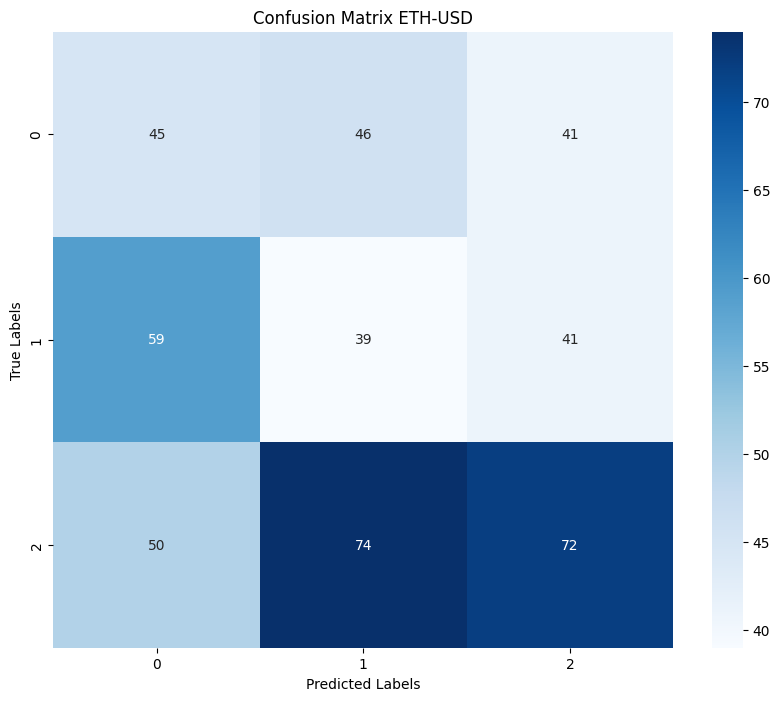

Classification Report for BTC-USD:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.00      0.00      0.00       160
           2       0.36      1.00      0.52       166

    accuracy                           0.36       467
   macro avg       0.12      0.33      0.17       467
weighted avg       0.13      0.36      0.19       467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


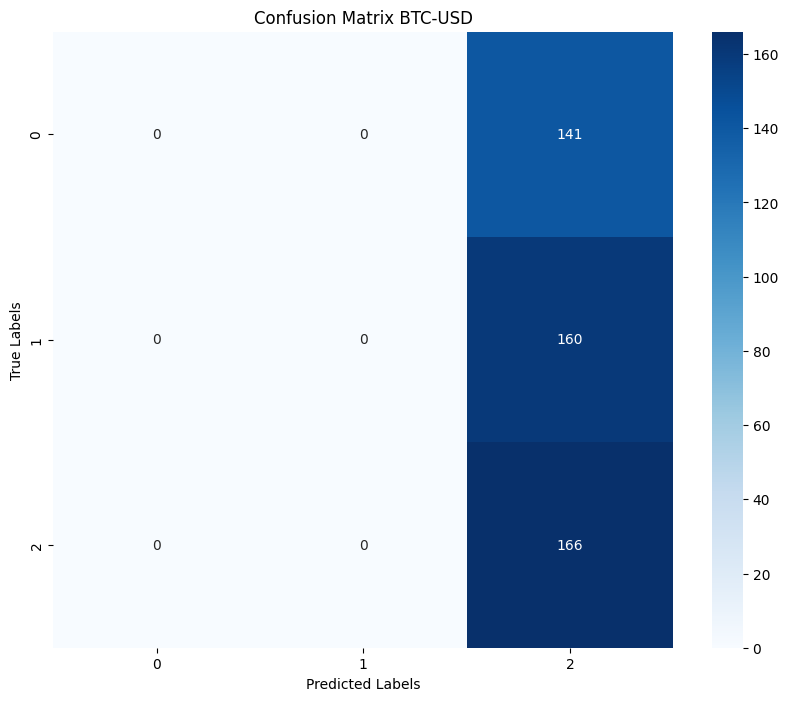

Classification Report for USDT-USD:
              precision    recall  f1-score   support

           0       0.29      0.37      0.32       120
           1       0.31      0.33      0.32       148
           2       0.47      0.37      0.41       199

    accuracy                           0.36       467
   macro avg       0.36      0.35      0.35       467
weighted avg       0.37      0.36      0.36       467



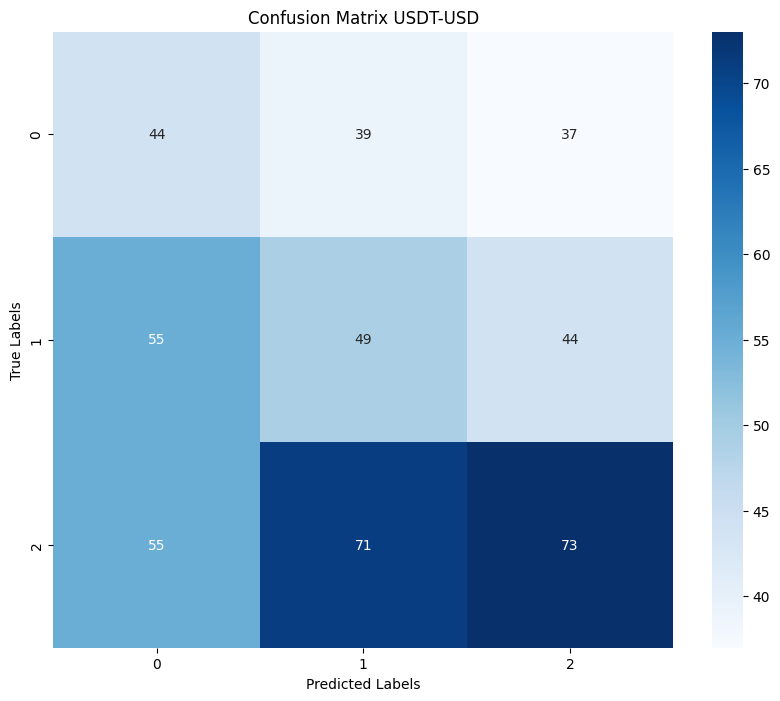

Classification Report for DOGE-USD:
              precision    recall  f1-score   support

           0       0.36      0.39      0.37       142
           1       0.45      0.41      0.43       177
           2       0.44      0.45      0.44       148

    accuracy                           0.42       467
   macro avg       0.42      0.42      0.41       467
weighted avg       0.42      0.42      0.42       467



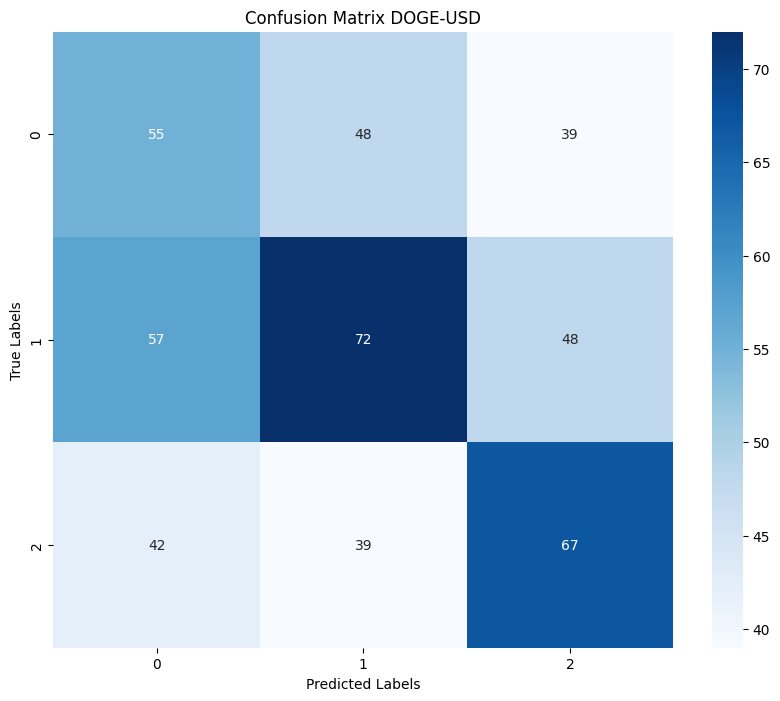

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix


labels = [0, 1, 2]
for ticker in cryptos:
  print(f"Classification Report for {ticker}:")
  print(classification_report(y_test[ticker], predicted_labels[ticker]))
  conf_matrix = confusion_matrix(y_test[ticker], predicted_labels[ticker])
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels= labels, yticklabels= labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix {ticker}')
  plt.show()

#### Percentile 66th and 33th - Buffering

**Buffered Percentile Rule**

Is an extension of the percentile technique that modifies the upper and lower limits in cases where probability are extremely near. By gradually expanding or contracting the thresholds, it adds another layer of caution to the probability' interpretation, noting that little deviations might not be significant.

**Limitation**

This buffering's drawback is that it requires careful calibration, even though it can help handle borderline cases and smooth out sudden classification changes. An incorrectly adjusted buffer might add bias or reduce the desired flexibility, which reduces the reliability of the decision boundaries.

In [ ]:
def classify_buffer(p, up_thresh, down_thresh, buffer = 0.05):
    if p > up_thresh + buffer:
        return 1
    elif p < down_thresh - buffer:
        return 0
    else:
        return 2

In [ ]:
predicted_labels = {}

for ticker in cryptos:
    max_probs = np.max(predictions[ticker], axis=1)
    up_thresh = np.percentile(max_probs, 66)
    down_thresh = np.percentile(max_probs, 33)
    refined_labels = []

    for i, probs in enumerate(predictions[ticker]):
        max_prob = np.max(probs)
        refined_labels.append(classify_buffer(max_prob, up_thresh, down_thresh))

    predicted_labels[ticker] = np.array(refined_labels)

Classification Report for ETH-USD:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       132
           1       0.00      0.00      0.00       139
           2       0.42      1.00      0.59       196

    accuracy                           0.42       467
   macro avg       0.14      0.33      0.20       467
weighted avg       0.18      0.42      0.25       467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


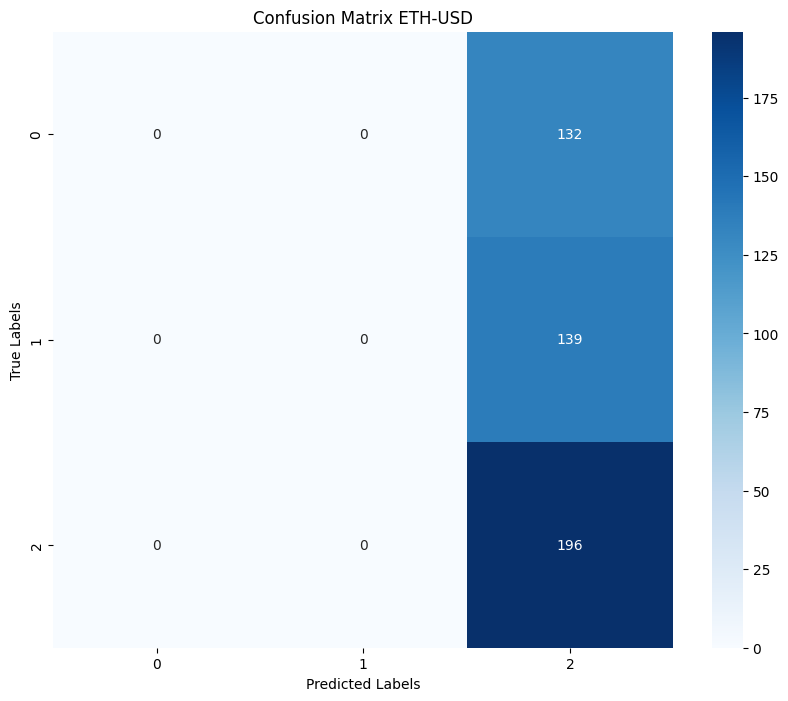

Classification Report for BTC-USD:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.00      0.00      0.00       160
           2       0.36      1.00      0.52       166

    accuracy                           0.36       467
   macro avg       0.12      0.33      0.17       467
weighted avg       0.13      0.36      0.19       467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


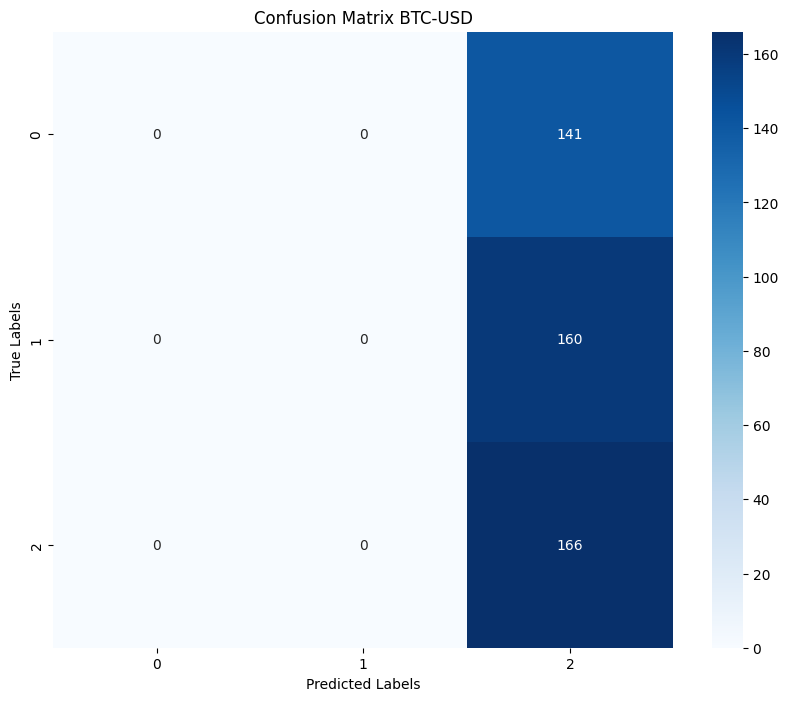

Classification Report for USDT-USD:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.00      0.00      0.00       148
           2       0.43      1.00      0.60       199

    accuracy                           0.43       467
   macro avg       0.14      0.33      0.20       467
weighted avg       0.18      0.43      0.25       467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


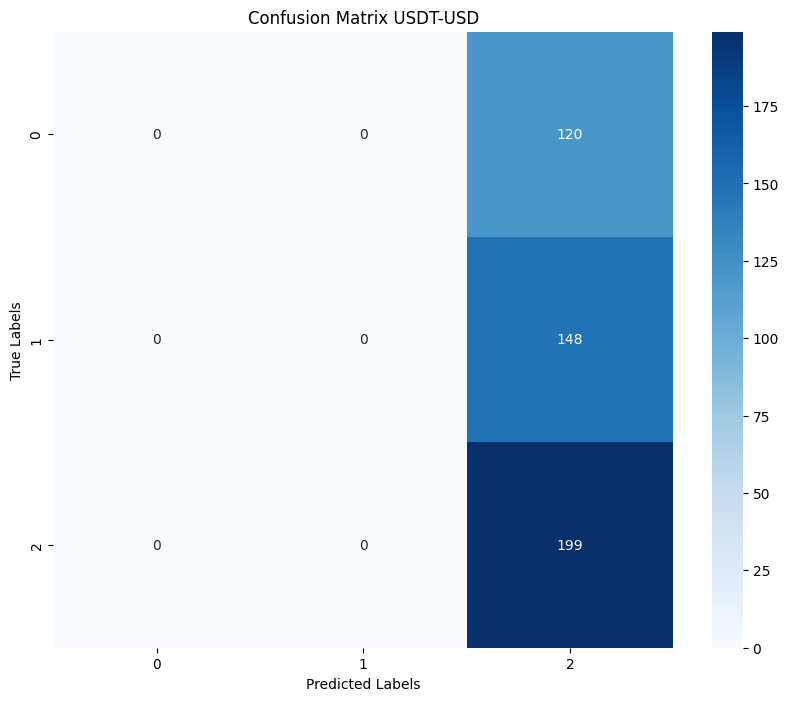

Classification Report for DOGE-USD:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.00      0.00      0.00       177
           2       0.32      1.00      0.48       148

    accuracy                           0.32       467
   macro avg       0.11      0.33      0.16       467
weighted avg       0.10      0.32      0.15       467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


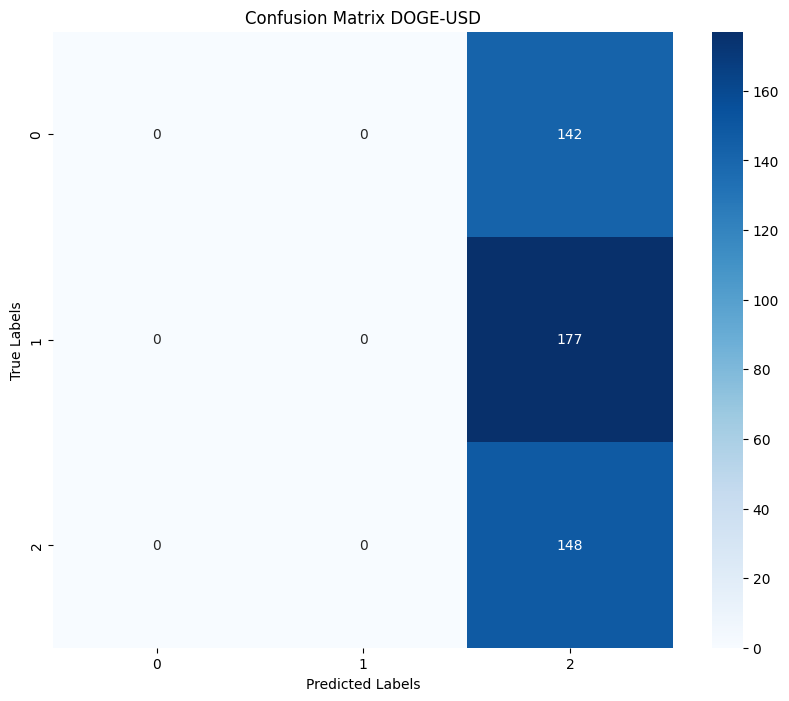

In [ ]:
import seaborn as sns
import pandas as pd
labels = [0, 1, 2]
for ticker in cryptos:
  print(f"Classification Report for {ticker}:")
  print(classification_report(y_test[ticker], predicted_labels[ticker]))
  conf_matrix = confusion_matrix(y_test[ticker], predicted_labels[ticker])
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels= labels, yticklabels= labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix {ticker}')
  plt.show()

#### Percentile 70th and 30th

**Percentile Rule (30th and 70th):**
This variation interprets the probability outputs with a little more distinction between low, medium, and high confidence forecasts by adjusting the thresholds to the 30th and 70th percentiles.

In situations where probability cluster densely, the goal is to enhance classification balance by expanding the gap for the middle category, which refines sensitivity.

***Limitation***

The drawback is that in some situations, these thresholds may be overly strict, which could lead to fewer observations falling into the intermediate category and oversimplifying the subtleties in borderline situations.

In [ ]:
def classify(p, up_thresh, down_thresh):
    if p > up_thresh:
        return 1
    elif p < down_thresh:
        return 0
    else:
        return 2

In [ ]:
predicted_labels = {}

for ticker in cryptos:
    max_probs = np.max(predictions[ticker], axis=1)
    up_thresh = np.percentile(max_probs, 70)
    down_thresh = np.percentile(max_probs, 30)
    refined_labels = []

    for i, probs in enumerate(predictions[ticker]):
        max_prob = np.max(probs)
        refined_labels.append(classify(max_prob, up_thresh, down_thresh))

    predicted_labels[ticker] = np.array(refined_labels)

Classification Report for ETH-USD:
              precision    recall  f1-score   support

           0       0.29      0.30      0.29       132
           1       0.26      0.26      0.26       139
           2       0.44      0.42      0.43       196

    accuracy                           0.34       467
   macro avg       0.33      0.33      0.33       467
weighted avg       0.34      0.34      0.34       467



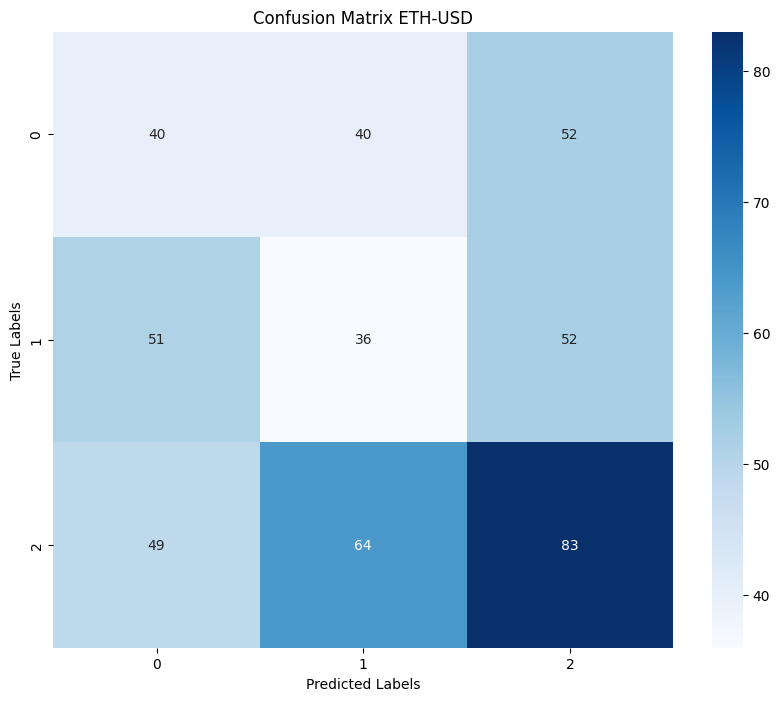

Classification Report for BTC-USD:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.00      0.00      0.00       160
           2       0.36      1.00      0.52       166

    accuracy                           0.36       467
   macro avg       0.12      0.33      0.17       467
weighted avg       0.13      0.36      0.19       467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


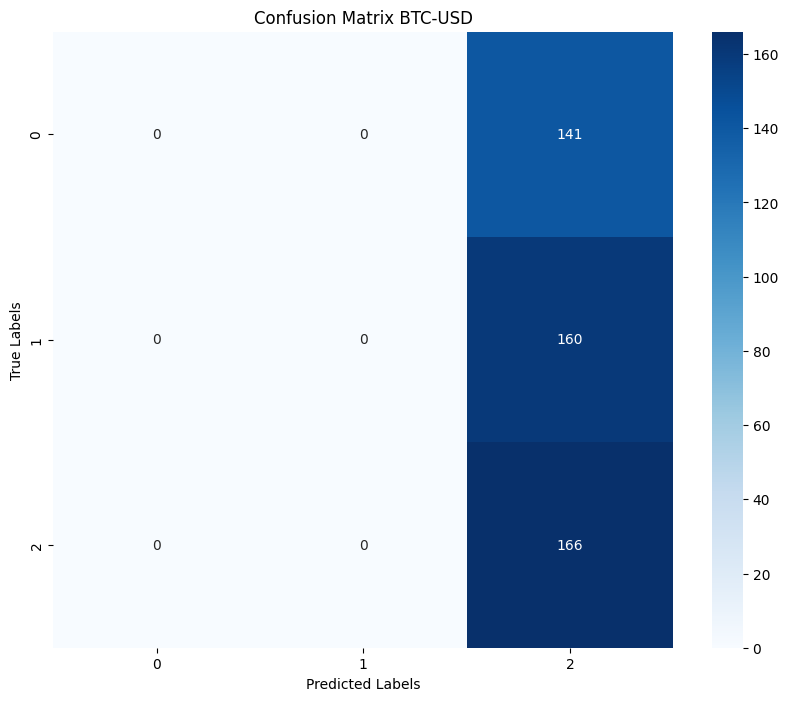

Classification Report for USDT-USD:
              precision    recall  f1-score   support

           0       0.30      0.35      0.32       120
           1       0.30      0.28      0.29       148
           2       0.48      0.45      0.46       199

    accuracy                           0.37       467
   macro avg       0.36      0.36      0.36       467
weighted avg       0.37      0.37      0.37       467



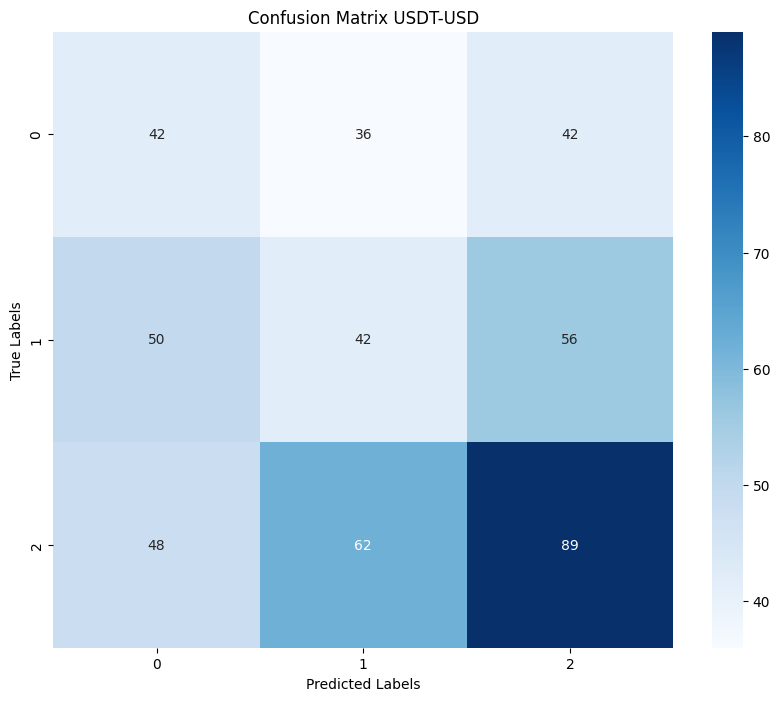

Classification Report for DOGE-USD:
              precision    recall  f1-score   support

           0       0.36      0.35      0.35       142
           1       0.45      0.36      0.40       177
           2       0.40      0.51      0.45       148

    accuracy                           0.40       467
   macro avg       0.40      0.40      0.40       467
weighted avg       0.41      0.40      0.40       467



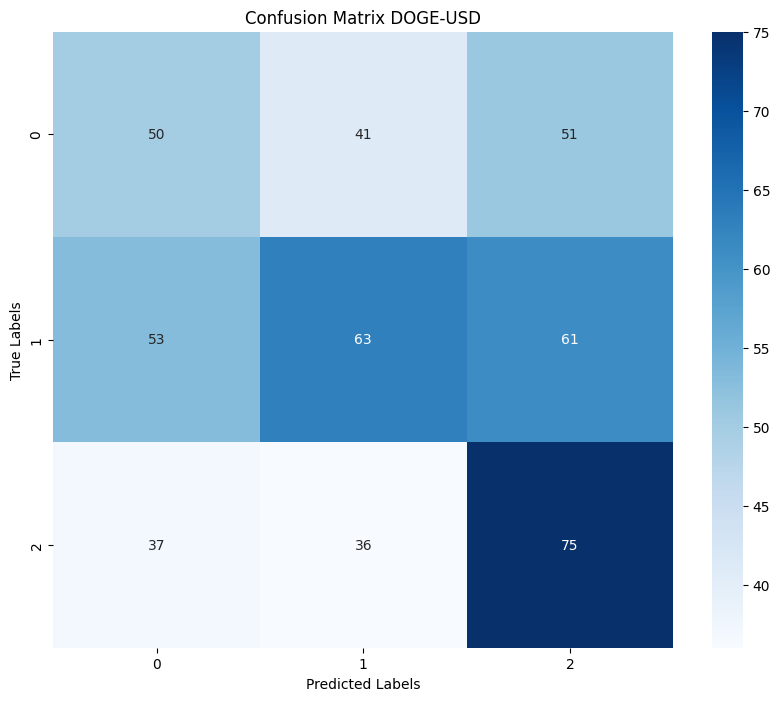

In [ ]:
import seaborn as sns
import pandas as pd
labels = [0, 1, 2]
for ticker in cryptos:
  print(f"Classification Report for {ticker}:")
  print(classification_report(y_test[ticker], predicted_labels[ticker]))
  conf_matrix = confusion_matrix(y_test[ticker], predicted_labels[ticker])
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels= labels, yticklabels= labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix {ticker}')
  plt.show()

#### Argmax Classification

The **Argmax Rule** interprets the model's output as its confidence in each class by allocating each observation to the category with the highest projected probability.

Essentially, it assumes that the top probability represents the actual underlying class and treats it as the model's best estimate.

***Limitation :***
* Its drawback, though, is that it cannot take uncertainty into account; in situations where probabilities are extremely close across classes, it compels a difficult choice without taking into consideration possible ambiguity. When class distributions are quite similar, this could be an issue.

In [ ]:
for ticker in cryptos:
  max_probs = np.argmax(predictions[ticker], axis=1)
  predicted_labels[ticker] = max_probs

Classification Report for ETH-USD:
              precision    recall  f1-score   support

           0       0.28      0.36      0.31       132
           1       0.28      0.60      0.38       139
           2       0.00      0.00      0.00       196

    accuracy                           0.28       467
   macro avg       0.19      0.32      0.23       467
weighted avg       0.16      0.28      0.20       467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


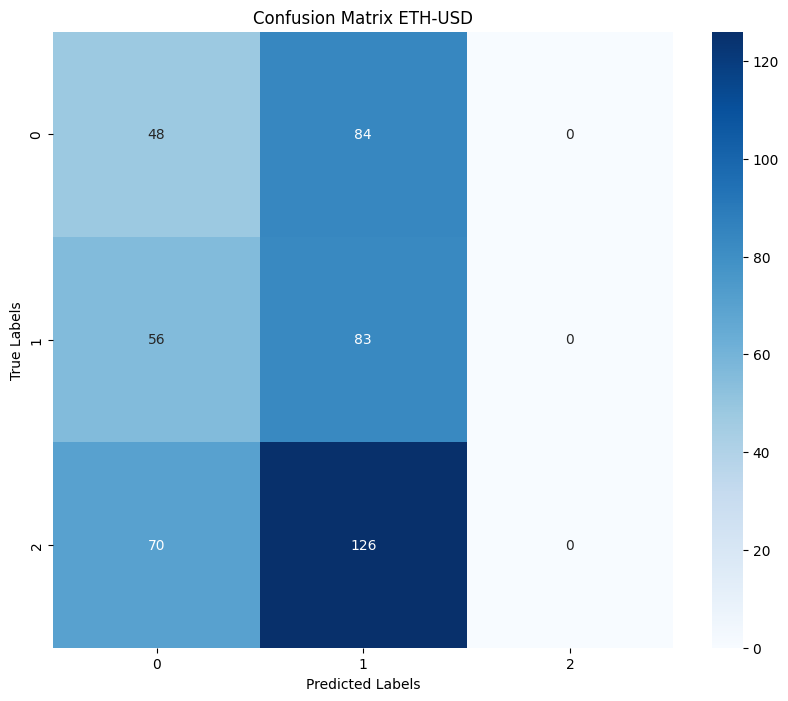

Classification Report for BTC-USD:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.00      0.00      0.00       160
           2       0.36      1.00      0.52       166

    accuracy                           0.36       467
   macro avg       0.12      0.33      0.17       467
weighted avg       0.13      0.36      0.19       467



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


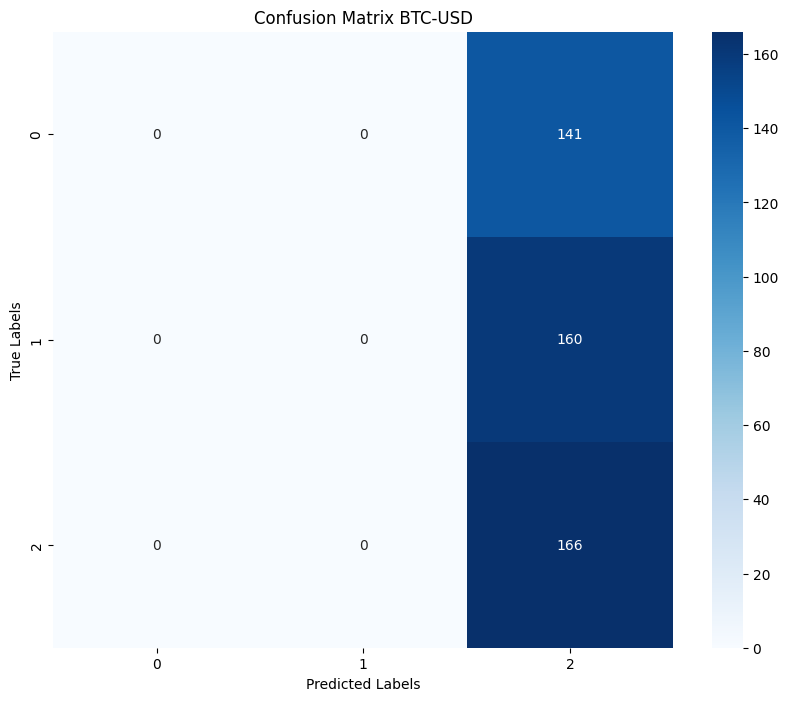

Classification Report for USDT-USD:
              precision    recall  f1-score   support

           0       0.25      0.75      0.37       120
           1       0.44      0.03      0.05       148
           2       0.34      0.16      0.21       199

    accuracy                           0.27       467
   macro avg       0.34      0.31      0.21       467
weighted avg       0.35      0.27      0.20       467



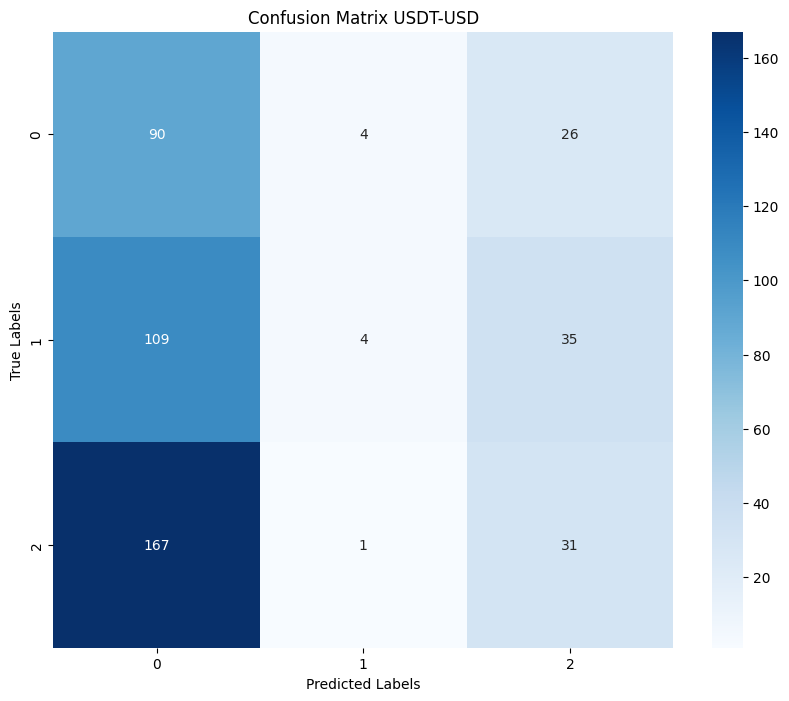

Classification Report for DOGE-USD:
              precision    recall  f1-score   support

           0       0.27      0.14      0.18       142
           1       0.44      0.50      0.47       177
           2       0.37      0.49      0.42       148

    accuracy                           0.39       467
   macro avg       0.36      0.37      0.36       467
weighted avg       0.37      0.39      0.37       467



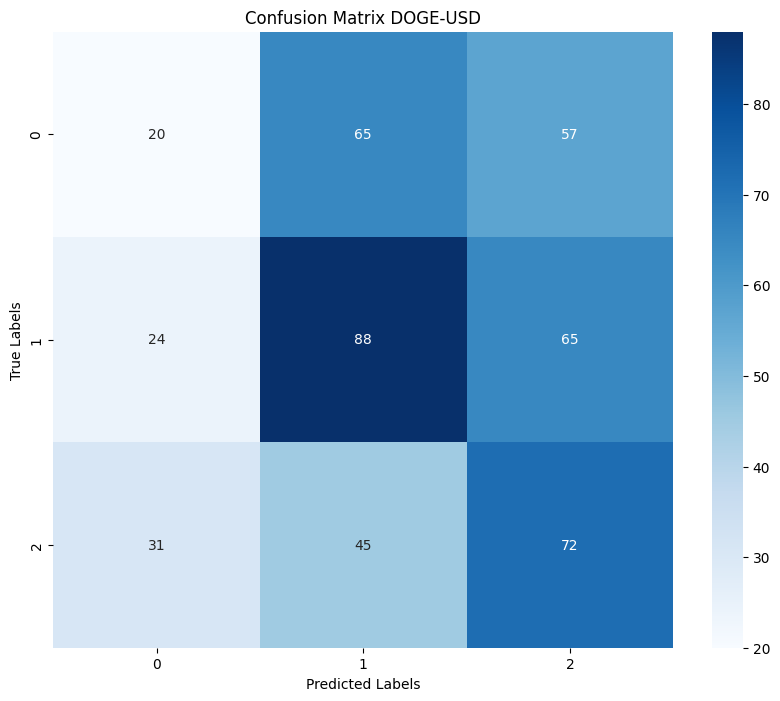

In [ ]:
import seaborn as sns
import pandas as pd
labels = [0, 1, 2]
for ticker in cryptos:
  print(f"Classification Report for {ticker}:")
  print(classification_report(y_test[ticker], predicted_labels[ticker]))
  conf_matrix = confusion_matrix(y_test[ticker], predicted_labels[ticker])
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels= labels, yticklabels= labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix {ticker}')
  plt.show()

## Random Forest

Since Feature Selection was already performed, in the following section we will focus on tuning hyper parameters.

We decided to use the **Bayesan Optimizer technique.**
Its strenght lies on reduced computational time.

***What:***
- Bayesan Optimization is a sequential model based on optimization
- It builds a probabilistic model, using a Gaussian process of the function and searches for the most efficents parameters.

- It learns from preavious evaluations by building a probability distribution of the hyperparameter performance, selecting the hyperparamter sets more intelligently

- Reduce thee number of model evaluation, cause it doesn't explore all the possible combination, like GridSearch, but only the more probable reducing computational time

***Hyperparameters:***
1. **n_estimator :** Define the number of decision trees in the Random Forest.
 * A higher number of trees improves model stability but increase training time
 * A low number of trees may resullt in high variance and overfitting

2. **max_depth :** The maximum depth allowed for each tree inside the model.

 * A three with a low depth (shallow tree) usually result in underfitting due to the inability of finding complex patterns
 * With very deep trees the model may overfitting by memorizing the training data

3. **min_sample_split :** The minimum number of samples required to split a node (dividing note into 'child' node)
 * With smaller value the number feature for splitting the samples is lower, leading to more depth tree and overfitting
 * Larger value create a less number of node leading to a shallow tree and high generalization of the data

4. **min_samples_leaf** minimum number of sample needed to create a leaf node.
  * Low value cfreate small leaf nodes, leading to overfitting
  * Higher values ensure that each leaf nodes had enough samples to improve generalization

5. **max_features :** control the number of features randomly selected for each tree

 * **sqrt** helps when there are many features in the dataset by selecting the square root of the number of features

 * **log2**

 * **None** take all the features from the dataset

6. **max_samples :** is used in order to control how mutch of the training sample will be used  to build each tree

  * 0.5 - 0.7 show a strong regularization, optimal for reducing overfitting
  * 0.7 - 0.9 Balanced between generalization and learning power

### Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Divide into train and test; Store into 2 separate dictionaries
train = {}
test = {}
for ticker in cryptos:
    train[ticker], test[ticker] = train_test_split(crypto_data[ticker], train_size=0.8, random_state=42)

# Predictors
predictors = crypto_data['BTC-USD'].columns.tolist()
predictors.remove('Target')
predictors.remove('TargetClass')
predictors.remove('Pct Return')

# Initialize the MinMaxScaler for scaling features
sc_x = MinMaxScaler(feature_range=(0, 1))

# Scale predictors for each ticker separately
for ticker in cryptos:
    # Fit and transform the training data
    train[ticker][predictors] = sc_x.fit_transform(train[ticker][predictors])
    test[ticker][predictors] = sc_x.transform(test[ticker][predictors])

### Hyperparameter Tuning:  Train & Predict

***Bayesian- Optimizer results:***
1. ***ETH-USD*** - ***USDT-USD***
- Relatively deep tree structure with **max_depth = 30,** allowing the model to capture intricate patterns in price movements.
- **max_features = None** means that all features are considered when determining the best split, likely all feature selected are fully contributing for model's decision making.
- **max_samples = 0.9** implies that each tree is trained on 90% of the available data.
- The other parameters (e.g., min_samples_split / min_sample_leaf) allow for prevention of overfitting.
- The n_estimators = 400 suggests a relatively large ensemble, reinforcing stability in predictions through aggregation.

2. ***BTC-USD***
- Slightly shorter tree (**max_depth = 26)** in comparison with ETH. Probably determined by different market behavior, market volatility or liquidity.
- The **max_features = None** means full feature utilization.
- **max_samples = 0.72**, meaning that each tree is trained on a smaller fraction of the data compared to ETH. This could imply that BTC price movements benefit from a slightly higher bias but reduced variance, likely due to stronger trends or noise in the dataset.
- **n_estimators = 360** (slightly lower than ETH) suggests that fewer trees are needed to achieve optimal accuracy.

3. ***DOGE-USD:***

- max_depth = 25, shortest tree across selected cryptos; likely, price direction may be captured with fewer splits.
- max_features = None means that all features are used.
max_samples = 0.9 → The dataset split remains similar to USDT and ETH.
min_samples_leaf = 5, min_samples_split = 10 → Same structure as ETH and USDT, ensuring consistency.
n_estimators = 50 → A significantly lower number of trees compared to the others, implying that the model stabilizes quickly on Dogecoin’s price behavior without requiring a large ensemble.

**Key Insights**:
- Stablecoins like USDT still require deep trees and large ensembles, possibly due to micro-fluctuations that require granular decision-making.
- Major assets (ETH, BTC) need more complex models, but BTC stabilizes with fewer samples.
- Meme coins (DOGE) exhibit a more simplistic classification pattern, requiring significantly fewer trees for optimal performance.



In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV

param_grid = {
    'n_estimators': (50, 400),
    'max_depth': (5, 30),
    'min_samples_split': (10, 30),
    'min_samples_leaf': (5, 30),
    'max_features': ['sqrt', 'log2', None],
    'max_samples': (0.5, 0.9)
}

Bayes_search = BayesSearchCV(
    estimator = RandomForestClassifier(),
    search_spaces = param_grid,
    n_iter = 30,
    random_state = 42,
    cv = 5, # Split the datasets into 5 folds, 4 will be used for training and the other one for validation. This process is repeated until all the 5 folds are used once as validation
    scoring = 'accuracy',
    verbose = 0,
    n_jobs = -1 # Uses al CPU node for faster computation
)

best_param = {}

for ticker in cryptos:
  col = filtered_importance[ticker].index
  Bayes_search.fit(train[ticker][col], train[ticker]['TargetClass'])
  best_param[ticker] = Bayes_search.best_params_
  print(f'Best parameter for dataset: {ticker} {best_param[ticker]}')

Best parameter for dataset: ETH-USD OrderedDict([('max_depth', 30), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 18), ('n_estimators', 227)])
Best parameter for dataset: BTC-USD OrderedDict([('max_depth', 21), ('max_features', None), ('max_samples', 0.7947106567906324), ('min_samples_leaf', 5), ('min_samples_split', 15), ('n_estimators', 326)])
Best parameter for dataset: USDT-USD OrderedDict([('max_depth', 16), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 50)])
Best parameter for dataset: DOGE-USD OrderedDict([('max_depth', 25), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 400)])


### Random Forest Classifier 1 - No additional Feature Selection

In [ ]:
# Predictions on Optimized Parameters; Accuracy Calculation
predictions = {}
importance_RF = {}
for ticker in cryptos:
  col = filtered_importance[ticker].index
  best_model = RandomForestClassifier(**best_param[ticker])
  best_model.fit(train[ticker][col], train[ticker]['TargetClass'])
  predictions[ticker] = best_model.predict(test[ticker][col])
  train_accuracy = best_model.score(train[ticker][col], train[ticker]['TargetClass'])
  test_accuracy = best_model.score(test[ticker][col], test[ticker]['TargetClass'])
  print( f'Dataset: {ticker}')
  print(f'Train Accuracy: {train_accuracy}')
  print(f'Test Accuracy: {test_accuracy}')
  print('------------------------------------------------------------------------------------')

Dataset: ETH-USD
Train Accuracy: 0.8530183727034121
Test Accuracy: 0.4276729559748428
------------------------------------------------------------------------------------
Dataset: BTC-USD
Train Accuracy: 0.8540682414698163
Test Accuracy: 0.46540880503144655
------------------------------------------------------------------------------------
Dataset: USDT-USD
Train Accuracy: 0.9406824146981627
Test Accuracy: 0.7861635220125787
------------------------------------------------------------------------------------
Dataset: DOGE-USD
Train Accuracy: 0.8939632545931758
Test Accuracy: 0.5073375262054507
------------------------------------------------------------------------------------


**1. ETH-USD:**
  - accuracy on the test set is 44.86%, which means it is slightly better than random. It might indicate high volatility and unpredictability in Ethereum's price movements, making it a challenging asset to predict.

**2. BTC-USD:**
  - The test accuracy of 45.7% is similar to ETH-USD.

**3. USDT-USD:**
  - The model performs exceptionally well on USDT, with a test accuracy of 79.66%. This high accuracy could be due to the stable nature of USDT (a stablecoin), where the price is designed to remain pegged to the US dollar. Predicting such a stable asset is easier compared to volatile cryptocurrencies.

**4. DOGE-USD:**
  - With a test accuracy of 50.1%, DOGE is somewhere in between the others, with more variability than USDT but potentially more predictable than ETH or BTC.

Dataset: ETH-USD
              precision    recall  f1-score   support

           0       0.43      0.42      0.43       149
           1       0.49      0.50      0.50       165
           2       0.42      0.42      0.42       163

    accuracy                           0.45       477
   macro avg       0.45      0.45      0.45       477
weighted avg       0.45      0.45      0.45       477



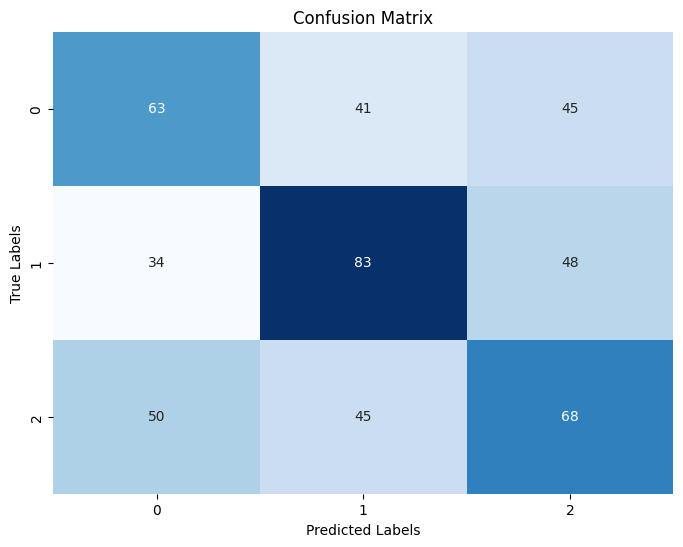

Dataset: BTC-USD
              precision    recall  f1-score   support

           0       0.48      0.45      0.47       148
           1       0.43      0.48      0.45       155
           2       0.46      0.44      0.45       174

    accuracy                           0.46       477
   macro avg       0.46      0.46      0.46       477
weighted avg       0.46      0.46      0.46       477



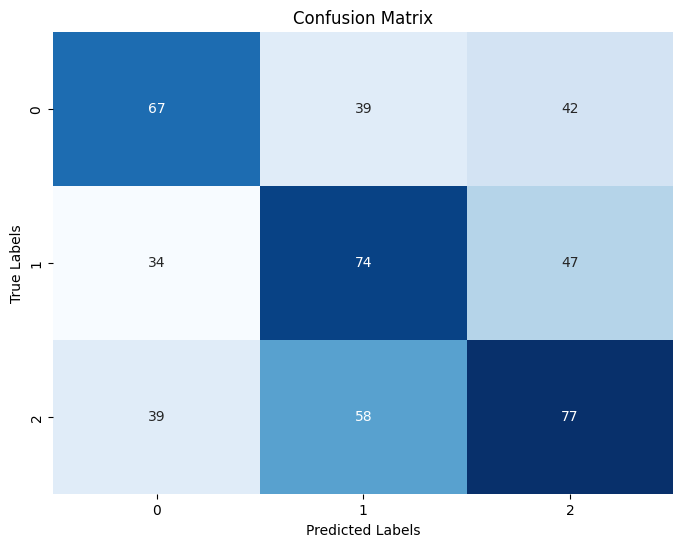

Dataset: USDT-USD
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       150
           1       0.82      0.79      0.81       160
           2       0.79      0.84      0.82       167

    accuracy                           0.80       477
   macro avg       0.80      0.79      0.80       477
weighted avg       0.80      0.80      0.80       477



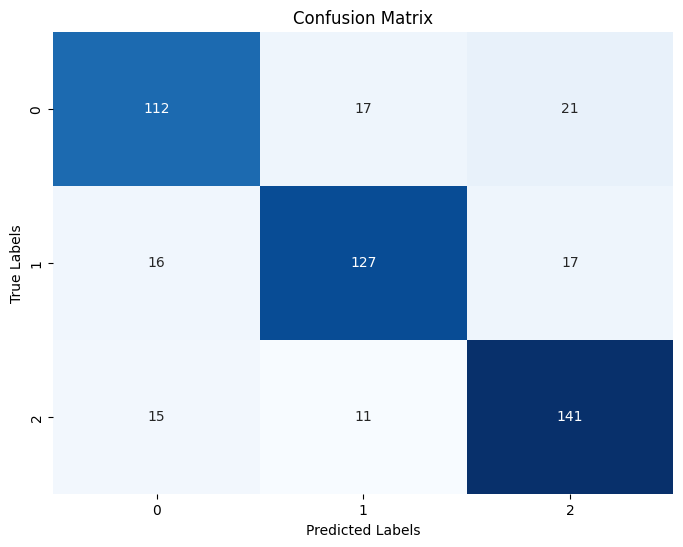

Dataset: DOGE-USD
              precision    recall  f1-score   support

           0       0.46      0.45      0.45       156
           1       0.54      0.51      0.52       161
           2       0.50      0.54      0.52       160

    accuracy                           0.50       477
   macro avg       0.50      0.50      0.50       477
weighted avg       0.50      0.50      0.50       477



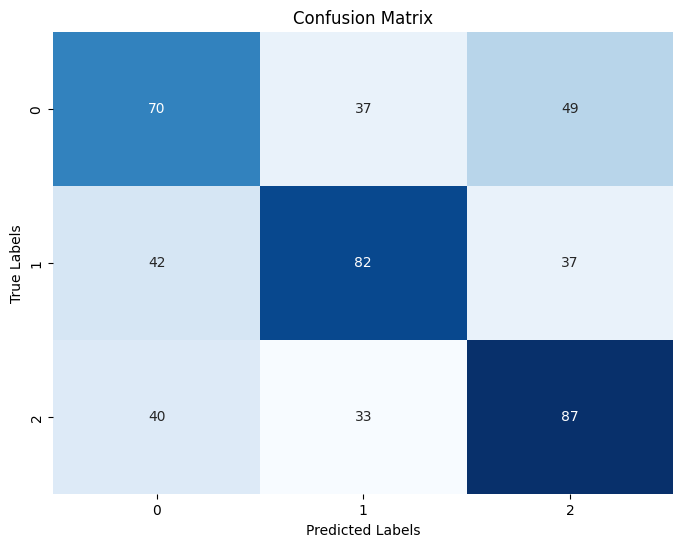

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report and Confusion Matrix
for ticker in cryptos:
  print(f'Dataset: {ticker}')
  print(classification_report(test[ticker]['TargetClass'], predictions[ticker]))
  conf_matrix = confusion_matrix(test[ticker]['TargetClass'], predictions[ticker])

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

- **ETH - USD:**
  - The F1-scores are fairly balanced between the three classes, but the low accuracy (45%) indicates that predictions are not reliable.

- **BTC-USD:**
  - Similar to ETH, with a slightly better F1-score for class 1, indicating some patterns in upward price movements.
  - Overall accuracy is still low.

- **USDT-USD**
  - High accuracy and balanced F1-scores across all classes.
  - Determined by its stability as a pegged asset.

- **DOGE-USD:**
  - The model performs reasonably well, especially for class 1 (moderate movements).
  - Accuracy for thus crypto is the highest.

### Random Forest Classifier 2 - Additional feature selection & Hyperparameter Tuning - Median Threshold

In [ ]:
predictions = {}
importance_RF = {}
for ticker in cryptos:
  col = filtered_importance[ticker].index
  best_model = RandomForestClassifier(**best_param[ticker])
  best_model.fit(train[ticker][col], train[ticker]['TargetClass'])
  predictions[ticker] = best_model.predict(test[ticker][col])
  train_accuracy = best_model.score(train[ticker][col], train[ticker]['TargetClass'])
  test_accuracy = best_model.score(test[ticker][col], test[ticker]['TargetClass'])
  print( f'Dataset: {ticker}')
  print(f'Train Accuracy: {train_accuracy}')
  print(f'Test Accuracy: {test_accuracy}')
  if train_accuracy - test_accuracy > 0.10:
    print('Overfitting')
    importance_RF[ticker] = best_model.feature_importances_
    importance_RF[ticker] = df_importance[ticker].apply(lambda x: x if x > np.percentile(df_importance[ticker],50) else np.nan)
    importance_RF[ticker] = importance_RF[ticker].dropna()
  else:
    print('No significant Overfitting')
    importance_RF[ticker] = pd.Series(best_model.feature_importances_, index = col)
  print(40 * '-')

Dataset: ETH-USD
Train Accuracy: 0.9244094488188976
Test Accuracy: 0.42557651991614254
Overfitting
----------------------------------------
Dataset: BTC-USD
Train Accuracy: 0.8640419947506561
Test Accuracy: 0.45073375262054505
Overfitting
----------------------------------------
Dataset: USDT-USD
Train Accuracy: 0.9359580052493438
Test Accuracy: 0.8029350104821803
Overfitting
----------------------------------------
Dataset: DOGE-USD
Train Accuracy: 0.8929133858267716
Test Accuracy: 0.5073375262054507
Overfitting
----------------------------------------


In [ ]:
pd.DataFrame(importance_RF)

,ETH-USD,BTC-USD,USDT-USD,DOGE-USD
AO,0.053233,0.056231,NaN,0.050101
Adj. Close,0.064399,0.067699,0.107315,0.068770
Bollinger_Lower,0.049057,0.047237,0.034503,0.044649
Bollinger_Upper,0.044037,0.042965,0.074046,0.045978
CCI,0.068410,0.069922,NaN,0.068089
Chikou_Span,0.055765,0.055780,NaN,0.053772
EMAF,NaN,NaN,0.040719,NaN
EMAM,NaN,NaN,0.033905,NaN
EMAS,0.041930,0.044803,0.039623,0.041786
Fib_0.236,NaN,NaN,0.036926,NaN


In [ ]:
for ticker in cryptos:
  col = importance_RF[ticker].index
  Bayes_search.fit(train[ticker][col], train[ticker]['TargetClass'])
  best_param[ticker] = Bayes_search.best_params_
  print(f'Best parameter for dataset: {ticker} {best_param[ticker]}')

Best parameter for dataset: ETH-USD OrderedDict([('max_depth', 18), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 400)])
Best parameter for dataset: BTC-USD OrderedDict([('max_depth', 24), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 285)])
Best parameter for dataset: USDT-USD OrderedDict([('max_depth', 19), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 400)])
Best parameter for dataset: DOGE-USD OrderedDict([('max_depth', 20), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 400)])


In [ ]:
predictions = {}
for ticker in cryptos:
  col = importance_RF[ticker].index
  best_model = RandomForestClassifier(**best_param[ticker])
  best_model.fit(train[ticker][col], train[ticker]['TargetClass'])
  predictions[ticker] = best_model.predict(test[ticker][col])
  train_accuracy = best_model.score(train[ticker][col], train[ticker]['TargetClass'])
  test_accuracy = best_model.score(test[ticker][col], test[ticker]['TargetClass'])
  print( f'Dataset: {ticker}')
  print(f'Train Accuracy: {train_accuracy}')
  print(f'Test Accuracy: {test_accuracy}')
  if train_accuracy - test_accuracy > 0.10:
    print('Overfitting')
  else:
    print('No significant Overfitting')

Dataset: ETH-USD
Train Accuracy: 0.9186351706036745
Test Accuracy: 0.5828092243186582
Overfitting
Dataset: BTC-USD
Train Accuracy: 0.8939632545931758
Test Accuracy: 0.5429769392033543
Overfitting
Dataset: USDT-USD
Train Accuracy: 0.9349081364829396
Test Accuracy: 0.8071278825995807
Overfitting
Dataset: DOGE-USD
Train Accuracy: 0.8750656167979003
Test Accuracy: 0.5241090146750524
Overfitting


Dataset: ETH-USD
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       149
           1       0.63      0.65      0.64       165
           2       0.54      0.52      0.53       163

    accuracy                           0.58       477
   macro avg       0.58      0.58      0.58       477
weighted avg       0.58      0.58      0.58       477



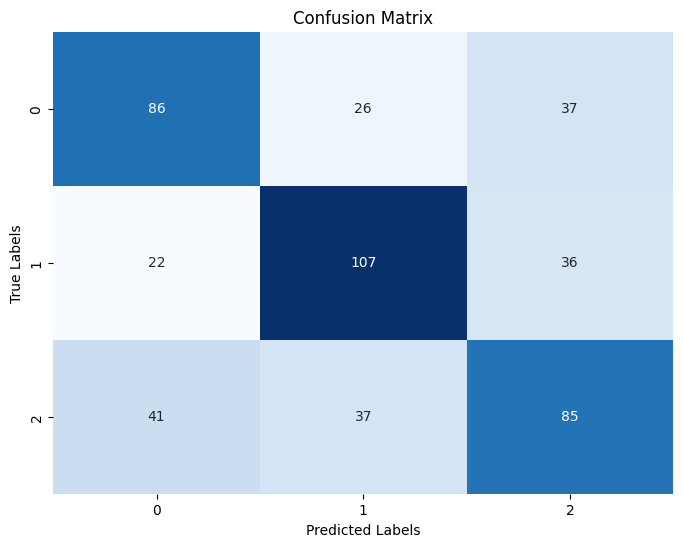

Dataset: BTC-USD
              precision    recall  f1-score   support

           0       0.59      0.54      0.56       148
           1       0.57      0.59      0.58       155
           2       0.49      0.50      0.49       174

    accuracy                           0.54       477
   macro avg       0.55      0.54      0.55       477
weighted avg       0.54      0.54      0.54       477



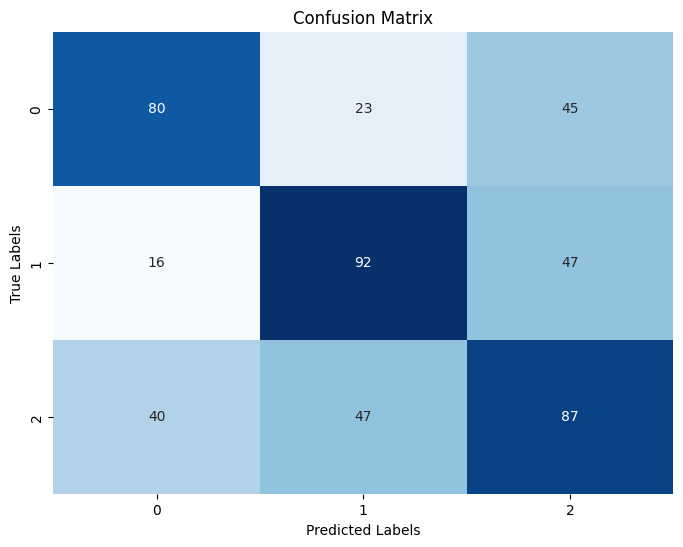

Dataset: USDT-USD
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       150
           1       0.82      0.80      0.81       160
           2       0.80      0.86      0.83       167

    accuracy                           0.81       477
   macro avg       0.81      0.81      0.81       477
weighted avg       0.81      0.81      0.81       477



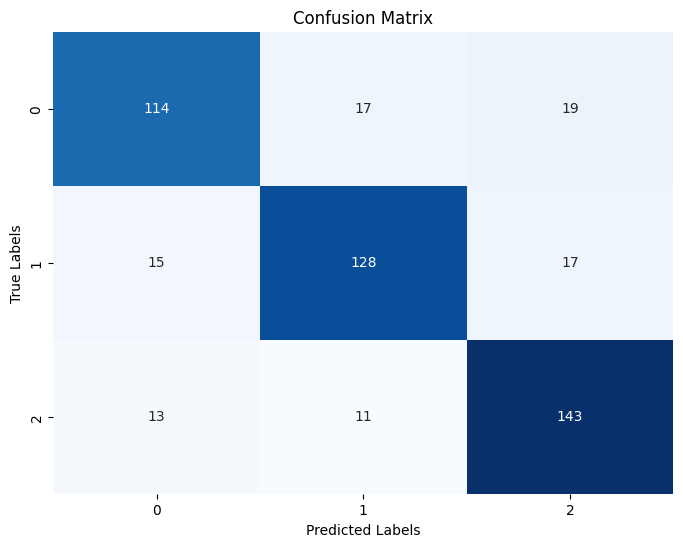

Dataset: DOGE-USD
              precision    recall  f1-score   support

           0       0.55      0.53      0.54       156
           1       0.56      0.50      0.52       161
           2       0.48      0.55      0.51       160

    accuracy                           0.52       477
   macro avg       0.53      0.52      0.52       477
weighted avg       0.53      0.52      0.52       477



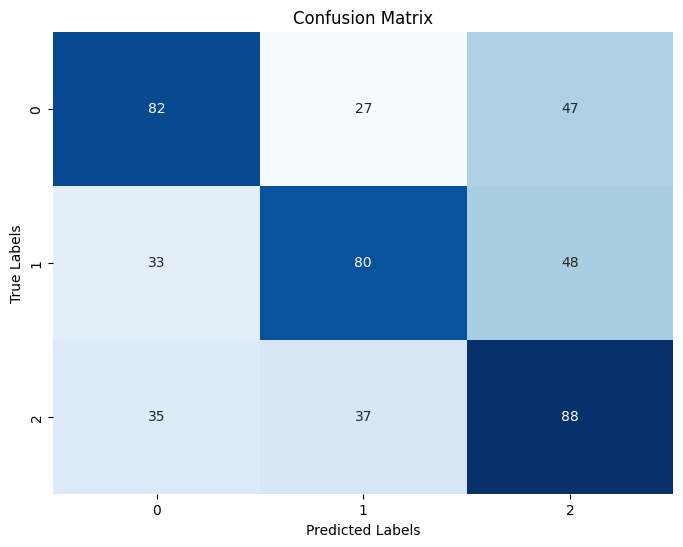

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report and Confusion Matrix
for ticker in cryptos:
  print(f'Dataset: {ticker}')
  print(classification_report(test[ticker]['TargetClass'], predictions[ticker]))
  conf_matrix = confusion_matrix(test[ticker]['TargetClass'], predictions[ticker])

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

### Random Forest Classifier 3 - Additional Feature Selection & Hyperparameter Tuning - Fixed Threshold

- If overfitting is detected by a fixed treshold (accuracy's difference >10%), feature importance is computed again.
- Once new features are selected; Optimization Bayesian algorithm is used again.
- New best parameters are found
- Random Classifier is trained once again on the new best parameters.
- Overfitting check is made.

In [ ]:
predictions = {}
importance_RF = {}
for ticker in cryptos:
  col = filtered_importance[ticker].index
  best_model = RandomForestClassifier(**best_param[ticker])
  best_model.fit(train[ticker][col], train[ticker]['TargetClass'])
  predictions[ticker] = best_model.predict(test[ticker][col])
  train_accuracy = best_model.score(train[ticker][col], train[ticker]['TargetClass'])
  test_accuracy = best_model.score(test[ticker][col], test[ticker]['TargetClass'])
  print( f'Dataset: {ticker}')
  print(f'Train Accuracy: {train_accuracy}')
  print(f'Test Accuracy: {test_accuracy}')
  if train_accuracy - test_accuracy > 0.10:
    print('Overfitting')
    importance_RF[ticker] = best_model.feature_importances_
    importance_RF[ticker] = df_importance[ticker].apply(lambda x: x if x > 0.05 else np.nan)
    importance_RF[ticker] = importance_RF[ticker].dropna()
  else:
    print('No significant Overfitting')
    importance_RF[ticker] = pd.Series(best_model.feature_importances_, index = col)
  print(40 * '-')

Dataset: ETH-USD
Train Accuracy: 0.8535433070866142
Test Accuracy: 0.44863731656184486
Overfitting
----------------------------------------
Dataset: BTC-USD
Train Accuracy: 0.8482939632545932
Test Accuracy: 0.46540880503144655
Overfitting
----------------------------------------
Dataset: USDT-USD
Train Accuracy: 0.9380577427821523
Test Accuracy: 0.8029350104821803
Overfitting
----------------------------------------
Dataset: DOGE-USD
Train Accuracy: 0.9002624671916011
Test Accuracy: 0.5136268343815513
Overfitting
----------------------------------------


In [ ]:
pd.DataFrame(importance_RF)

,ETH-USD,BTC-USD,USDT-USD,DOGE-USD
AO,0.053233,0.056231,NaN,0.050101
Adj. Close,0.064399,0.067699,0.107315,0.068770
Bollinger_Upper,NaN,NaN,0.074046,NaN
CCI,0.068410,0.069922,NaN,0.068089
Chikou_Span,0.055765,0.055780,NaN,0.053772
High,0.050646,0.051431,0.071144,0.056475
Low,0.052713,0.050588,0.054464,NaN
Open,0.080238,0.078144,0.131787,0.080491
RSI,0.071317,0.071534,0.082029,0.068888


In [ ]:
for ticker in cryptos:
  col = importance_RF[ticker].index
  Bayes_search.fit(train[ticker][col], train[ticker]['TargetClass'])
  best_param[ticker] = Bayes_search.best_params_
  print(f'Best parameter for dataset: {ticker} {best_param[ticker]}')

Best parameter for dataset: ETH-USD OrderedDict([('max_depth', 30), ('max_features', 'sqrt'), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 13), ('n_estimators', 50)])
Best parameter for dataset: BTC-USD OrderedDict([('max_depth', 30), ('max_features', 'log2'), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 299)])
Best parameter for dataset: USDT-USD OrderedDict([('max_depth', 30), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 400)])
Best parameter for dataset: DOGE-USD OrderedDict([('max_depth', 20), ('max_features', None), ('max_samples', 0.9), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 349)])


In [ ]:
predictions = {}
for ticker in cryptos:
  col = importance_RF[ticker].index
  best_model = RandomForestClassifier(**best_param[ticker])
  best_model.fit(train[ticker][col], train[ticker]['TargetClass'])
  predictions[ticker] = best_model.predict(test[ticker][col])
  train_accuracy = best_model.score(train[ticker][col], train[ticker]['TargetClass'])
  test_accuracy = best_model.score(test[ticker][col], test[ticker]['TargetClass'])
  print( f'Dataset: {ticker}')
  print(f'Train Accuracy: {train_accuracy}')
  print(f'Test Accuracy: {test_accuracy}')
  if train_accuracy - test_accuracy > 0.10:
    print('Overfitting')
  else:
    print('No significant Overfitting')

Dataset: ETH-USD
Train Accuracy: 0.8551181102362204
Test Accuracy: 0.4591194968553459
Overfitting
Dataset: BTC-USD
Train Accuracy: 0.8902887139107611
Test Accuracy: 0.480083857442348
Overfitting
Dataset: USDT-USD
Train Accuracy: 0.9322834645669291
Test Accuracy: 0.8155136268343816
Overfitting
Dataset: DOGE-USD
Train Accuracy: 0.9076115485564304
Test Accuracy: 0.5744234800838575
Overfitting


- Reduced the magnitude of accuracy's difference between train and test, for all cryptos.

- High accuracy for USDT , as expected.

- This further feature selection determined by a fixed threshold (established by looking at the features importance; T= 0.01), has caused a significant reduction in the feature space.
- Higher test accuracy for all cryptos. The feature selection possibly determined a better understanding of patterns.

**Key insights for Random Forest:**
- The overfitting detected also here undermines the goal of using machine leraning predictions for our further analysis in practical implementation in portfolio management, in a market characterized by rapid change and high volatility.
- Further feature selection helped us to detect which were the more relevant signals for the data, improving therefore model’s predictive ability.
- **The practical issue in this context is that our model is learning really well from historical data but will eventually fail in real-word applications , in which changes are not determined by past trends but rather from news and sentiment**.

## Dynamic Portfolio Allocation

Investment allocation is dynamically adjusted based on predictions, evaluated on RandomForestClassifier, for asset movements (up, down or neutral).

***Investment Allocation Process***

We assign different investment percentages to each cryptocurrency based on its predicted movement.

  * Up → 50% of the capital.
  * Neutral → Allocate 30% of the capital.
  * Down → Allocate 20% of the capital.

Regularization on the weight is applied in order to overcome the possibility that the model over-allocate capital beyond 100%

***Portfolio Growth Calculation***

* The **weights** are multiplied by the historical percentage returns of each asset, for all observation in the defined period, defining how much each crypto contributes to portfolio growth.

* The sum of returns: The weighted returns for all assets are summed to obtain the overall portfolio return for each time period.

* The **cumulative growth** return is computed over time, allowing  visualization of how the portfolio evolves.

Due to the classification nature of our model using traditional method was not feasible, cause we cannot evaluate the magnitude of the predictions. This approach is an alternative way that aims to optimize capital allocation, giving more importance to assets with an higher probability of positive movements.

We decide to use, as a benchmark, an **equal weight portfolio**, beacuse:
* It represent a neautral investment strategie
* And sets the contribution of all assets equally

In [ ]:
window = 5
agg = {}
for ticker in cryptos:
  agg[ticker] = pd.Series(predictions[ticker]).rolling(window = window).apply(lambda x: x.value_counts().idxmax(), raw = False)
  agg[ticker] = agg[ticker].dropna()

In [ ]:
pd.DataFrame(agg)

,ETH-USD,BTC-USD,USDT-USD,DOGE-USD
4,2.0,0.0,2.0,0.0
5,1.0,2.0,0.0,2.0
6,2.0,2.0,0.0,2.0
7,0.0,2.0,2.0,0.0
8,0.0,2.0,2.0,2.0
...,...,...,...,...
472,1.0,2.0,2.0,1.0
473,0.0,2.0,0.0,0.0
474,0.0,1.0,1.0,2.0
475,0.0,2.0,1.0,2.0


RMSE (Prediction Accuracy): 0.02021


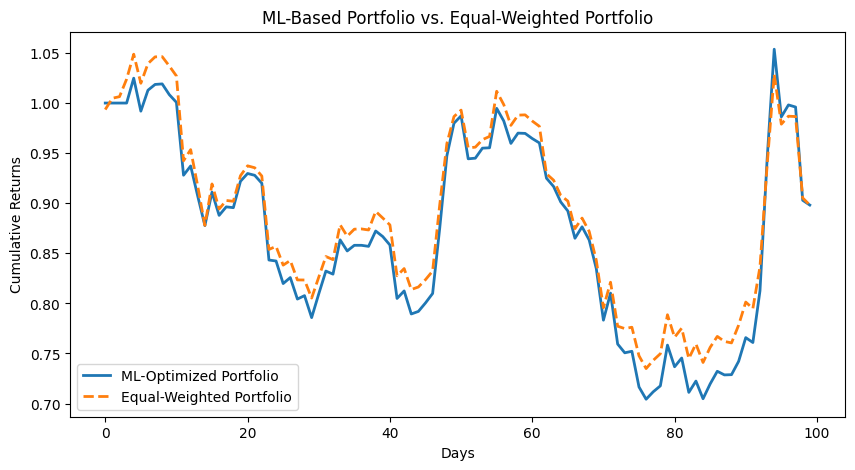

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

historical_returns = pd.DataFrame()
for ticker in cryptos:
    historical_returns[ticker] = crypto_data[ticker]['Pct Return']

predictions = pd.DataFrame()
for i, ticker in enumerate(cryptos):
    predictions[ticker] = pd.DataFrame(agg).iloc[range(0, 96), i]

def allocate_weights(predictions):
    weights = predictions.copy()
    allocation_map = {0: 0.2, 2: 0.3, 1: 0.5}
    for col in weights.columns:
        weights[col] = weights[col].replace(allocation_map)

    weights = weights.div(weights.sum(axis=1), axis=0)
    return weights

weights_dynamic = allocate_weights(predictions)


strategy_returns = (weights_dynamic * historical_returns.iloc[:100]).sum(axis=1)
cumulative_strategy_returns = (1 + strategy_returns).cumprod()

equal_weights = 1 / len(historical_returns.columns)
equal_weighted_returns = (historical_returns.iloc[:100] * equal_weights).sum(axis=1)
cumulative_equal_weighted_returns = (1 + equal_weighted_returns).cumprod()

rmse_portfolio = np.sqrt(mean_squared_error(cumulative_equal_weighted_returns, cumulative_strategy_returns))
print(f"RMSE: {rmse_portfolio:.5f}")

plt.figure(figsize=(10, 5))
plt.plot(cumulative_strategy_returns, label="ML-Optimized Portfolio", linewidth=2)
plt.plot(cumulative_equal_weighted_returns, label="Equal-Weighted Portfolio", linestyle='dashed', linewidth=2)
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.title("ML-Based Portfolio vs. Equal-Weighted Portfolio")
plt.legend()
plt.show()


The graph shows different instances in which the model briefly outperformed or underperformed the benchmark, but this difference are not significant to asses a major difference between the two strategies.

## Key Findings, Limitations and Suggestions

 - Even with feature selection and hyperparameter tuning, predicting crypto market movements remains challenging.
 - Traders and investors in these markets should be cautious when relying on machine learning models for price predictions and consider incorporating other strategies, such as technical analysis, sentiment analysis, and market trend forecasting, to improve decision-making.

Despite volatility, selected features and overfitting, our best model successfully outperformed a random selector, reaching to 60% validation accuracy also for very highly volatile cryptos (e.g., DOGE). Our approach was capable of detecting meaningful patterns.

In conclusion, our best model is perfectly capable of predicting from historical data but overfitting and the selected features undermines our model’s applicability to real world scenarios.

Stablecoins are more predictable due to their design, while volatile assets determine a greater challenge.

- For more **stable assets** (like USDT), we can assess that **machine learning models **could be incorporated into **automated trading strategies.**
- For **highly volatile** cryptocurrencies (e.g., BTC, ETH), risk management practices must be enhanced, and machine learning models should be used with caution.
- Possible solutions for improving machine learning models could include:
  - Alternative data sources, such as macro indicators (e.g., inflation rates,interest rates);
  - Integrate with sentiment and news data;


The strategies applied using RandomForest prediction to evaluate capital allocation for portfolio optimization did not outperform or underperform the equal weighted-benchmark. The value of the RMSE (0.021) indicate that cumulative returns are very similar in both strategies, showing no major difference between the two.

An important consideration to take into account is that we assume fixed investment threshold for the movement (up = 0.5, down =  0.2 and neutral = 0.3), this lead to a lack of flexibility inside the model. **This is a strong assumption** that might fail to fully capture specific volatility an momentum.

In conclusion while this study demonstrates the potential for machine learning to guide investment allocation, the fixed-weight assumption and directional-only predictions limit its effectiveness. The results highlight that model assumptions play a critical role in portfolio performance, and future improvements should focus on adaptive, data-driven investment strategies that account for both risk and return magnitude.
